# **EP3**
*Nome:* Monica Maria Funk Drechsler (11275391)


## **Introdução**
Dando continuidade à atividade proposta na Quick Task 3, neste notebook implementaremos um modelo de tradução sequência para sequência (Seq2Seq) utilizando Redes Neurais Recorrentes (RNNs) para converter datas no formato legível por humanos (como "12 de outubro de 2024") para um formato legível por máquinas (como "12/10/2024").

### **Contexto**

Modelos Seq2Seq são amplamente utilizados em tarefas que envolvem a transformação de uma sequência de entrada em outra sequência de saída, como tradução automática de idiomas, sumarização de texto e, neste caso, a transformação de formatos de data. Esses modelos geralmente consistem em dois componentes principais:

1. **Encoder**: Lê e compreende a sequência de entrada (neste caso, a data no formato legível por humanos).
2. **Decoder**: Gera a sequência de saída correspondente (a data no formato legível por máquinas).

### **Objetivo**

 O objetivo desta tarefa é aplicar os conceitos discutidos nos artigos "Sequence to Sequence Learning with Neural Networks" e "Neural Machine Translation by Jointly Learning to Align and Translate", utilizando-os em um problema de tradução de formatos de datas. Este exercício servirá como um exemplo prático do poder dos modelos Seq2Seq e do uso de RNNs em tarefas de tradução.

 Você deve rodar o código e tentar entender o que está acontecendo nas primeiras três seções. À medida que você se familiariza com a implementação, sinta-se à vontade para continuar a exploração em algum caminho que você achar interessante. Isso pode incluir experimentar diferentes configurações de modelo, aplicar novos datasets ou investigar alternativas aos mecanismos de atenção. O objetivo é que você desenvolva uma compreensão mais profunda dos modelos Seq2Seq e das suas aplicações práticas.

Este notebook possui as seguintes seções:

1. **Carregando os dados:** Iremos carregar um dataset pronto e em seguida converteremos as datas no formato de string para um formato numérico para que o modelo possa entender.
2. **Construção do modelo sem atenção:** Implementaremos o modelo Seq2Seq com base em GRU, uma variante das RNNs.
3. **Adicionando atenção:** Implementaremos uma versão do Decoder com atenção.
4. **Exercícios de Exploração Sugeridos:** Sugestões de explorações para que você possa explorar um pouco mais a tarefa.



### **Referências**

Este EP foi baseado em dois notebooks, do primeiro retirou a ideia do dataset [1] e o código PyTorch foi adaptado do segundo [2]. Revisão no texto e alguns comentários nos códigos foram gerados com ChatGPT.

[1] “Coursera-Deep-Learning-Specialization/C5 - Sequence Models/Week 3/Machine Translation/Neural Machine Translation with Attention - v4.Ipynb at Master · Amanchadha/Coursera-Deep-Learning-Specialization”. GitHub, https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C5%20-%20Sequence%20Models/Week%203/Machine%20Translation/Neural%20machine%20translation%20with%20attention%20-%20v4.ipynb.

[2] NLP From Scratch: Translation with a Sequence to Sequence Network and Attention — PyTorch Tutorials 2.4.0+cu121 documentation. Por Sean Robertson. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html.



----
# 0. Setup

In [ ]:
import random
import re
import time
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import gdown

plt.switch_backend('agg')
%matplotlib inline

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device={device}')

device=cuda


----
## 1. **Carregando os dados**

Iremos carregar um dataset pronto e em seguida converteremos as datas no formato de string para um formato numérico que o modelo possa entender.

Vamos treinar o modelo em um dataset de 10.000 datas legíveis por humanos e suas equivalentes, padronizadas, legíveis por máquinas.

In [ ]:
def readDataset():
  url = 'https://drive.google.com/uc?id=1REoydh9WkcbiiOvRoGSFGz-usDwQdgQ6' ##Apenas um ajuste para fazer o upload dos dados no Colab
  file = 'datahumana-datamaquina.txt'
  gdown.download(url, file, quiet=False)
  lines = open(file, encoding='utf-8').read().strip().split('\n')
  pairs = [[s for s in l.split('\t')] for l in lines]
  print()
  print(f'Read {len(pairs)} samples from {file}')
  print()
  print("\n".join(map(str, random.sample(pairs, 15))))
  return pairs
pairs = readDataset()

Downloading...
From: https://drive.google.com/uc?id=1REoydh9WkcbiiOvRoGSFGz-usDwQdgQ6
To: /content/datahumana-datamaquina.txt
100%|██████████| 328k/328k [00:00<00:00, 27.9MB/s]


Read 10000 samples from datahumana-datamaquina.txt

['25 de abril de 1990', '25/04/1990']
['sexta-feira 11 de junho de 1976', '11/06/1976']
['23 02 16', '23/02/2016']
['13.10.75', '13/10/1975']
['25 jul. 2009', '25/07/2009']
['domingo 23 de dezembro de 1990', '23/12/1990']
['26 de jun. de 1990', '26/06/1990']
['domingo 15 de agosto de 1976', '15/08/1976']
['07/06/2002', '07/06/2002']
['sexta-feira 13 de marco de 2020', '13/03/2020']
['quinta-feira 26 de dezembro de 2013', '26/12/2013']
['10/09/2017', '10/09/2017']
['25 abr. 2005', '25/04/2005']
['20 02 06', '20/02/2006']
['8 jul. 1990', '08/07/1990']


É necessário codificar as entradas e saídas em representações que o modelo consiga entender. Neste caso, representaremos as 'palavras' como inteiros atribuídos de forma sequencial.


Além disso, é necessário definir os tokens especiais para o início e fim de uma sequência.
- SOS_token (Start of Sequence - Início da Sequência) é usado para inicializar a entrada do decodificador ao gerar frases.
- EOS_token (End of Sequence - Fim da Sequência) indica o fim da frase, para que o decodificador saiba quando parar de gerar.


In [ ]:
SOS_token = 0
EOS_token = 1

def prepareData(pairs):
  input_dict  = {"SOS": SOS_token, "EOS": EOS_token}
  output_dict = {"SOS": SOS_token, "EOS": EOS_token}

  input_dict_reverse  = {SOS_token: "SOS", EOS_token: "EOS"}
  output_dict_reverse = {SOS_token: "SOS", EOS_token: "EOS"}

  for pair in pairs:
    ipt, tgt = pair

    mask = '([^a-zA-Z0-9])'
    result = [token for token in re.split(mask, ipt) if token.strip()]
    for word_input in result:
      if word_input not in input_dict:
        next_int = max(input_dict.values()) + 1
        input_dict[word_input] = next_int
        input_dict_reverse[next_int] = word_input

    for word_output in re.split(mask, tgt):
      if word_output not in output_dict:
        next_int = max(output_dict.values()) + 1
        output_dict[word_output] = next_int
        output_dict_reverse[next_int] = word_output

  print(f'Number of input words: {len(input_dict.keys())}')
  print(f'Number of output words: {len(output_dict.keys())}')

  return input_dict, output_dict, input_dict_reverse, output_dict_reverse

input_dict, output_dict, input_dict_reverse, output_dict_reverse = prepareData(pairs)

Number of input words: 164
Number of output words: 89


In [ ]:
def indexesFromSentence(language_dict, sentence, verbose=False):
  '''
    Função utilitária para converter uma sentença em índices
  '''
  encoded = [language_dict[word] for word in re.split('([^a-zA-Z0-9])', sentence) if word.strip()]
  if verbose:
    print(f"'{sentence}' => {encoded}")
  return encoded

indexesFromSentence(input_dict, 'segunda-feira 18 de outubro de 1999', verbose=True);
indexesFromSentence(output_dict, '30/09/2022', verbose=True);


'segunda-feira 18 de outubro de 1999' => [33, 11, 12, 102, 7, 66, 7, 39]
'30/09/2022' => [46, 3, 7, 3, 47]


In [ ]:
# Funções utilitárias
def tensorFromSentence(language_dict, sentence):
  indexes = indexesFromSentence(language_dict, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_dict, pair[0])
    target_tensor = tensorFromSentence(output_dict, pair[1])
    return (input_tensor, target_tensor)

tensorsFromPair(['segunda-feira 18 de outubro de 1999', '18/10/1999'])

(tensor([[ 33,  11,  12, 102,   7,  66,   7,  39,   1]]),
 tensor([[65,  3, 11,  3, 28,  1]]))

### Implementando data loader para treinamento

In [ ]:
def get_dataloader(batch_size, pairs, input_dict, output_dict):
  n = len(pairs)
  input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
  target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

  for idx, (inp, tgt) in enumerate(pairs):
    inp_ids = indexesFromSentence(input_dict, inp)
    tgt_ids = indexesFromSentence(output_dict, tgt)
    inp_ids.append(EOS_token)
    tgt_ids.append(EOS_token)
    input_ids[idx, :len(inp_ids)] = inp_ids
    target_ids[idx, :len(tgt_ids)] = tgt_ids

  train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))

  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  return train_dataloader

----
## 2. **Construção do modelo sem atenção:**

Dando continuidade, vamos implementar o modelo Seq2Seq utilizando a célula GRU.

Uma rede Encoder-Decoder é composta por duas RNNs: o Encoder e o Decoder.
O Encoder lê uma sequência de entrada e gera um vetor único, que o Decoder usa para produzir a sequência de saída.

Por simplicidade, utilizaremos a célula GRU. Como sugestão, você também pode explorar outras células RNN, como, por exemplo, a LSTM.

In [ ]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size, dropout_p=0.1):
    """
    Initializes the encoding layer (Encoder) of an RNN.

    Parameters:
    - input_size: The number of expected features in the input x
    - hidden_size: The number of features in the hidden state h
    - dropout_p: If non-zero, introduces a Dropout layer on the outputs of each GRU layer except the last layer
    """
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    # Embedding layer that transforms word indices into dense vectors of size 'hidden_size'.
    self.embedding = nn.Embedding(input_size, hidden_size)

    # Defines the GRU (Gated Recurrent Unit) with both input and output dimensions of 'hidden_size'.
    # 'batch_first=True' indicates that the first input dimension is the batch (batch_size, seq_len, hidden_size).
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    # Dropout applied after the embedding layer to prevent overfitting.
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, input):
    """
    Defines the forward pass of the model.

    Parameter:
    - input: Sequence of word indices of size (batch_size, seq_len).

    Returns:
    - output: GRU outputs for each step in the sequence (batch_size, seq_len, hidden_size).
    - hidden: The last hidden state vector of the GRU (1, batch_size, hidden_size).
        """
    embedded = self.dropout(self.embedding(input))
    output, hidden = self.gru(embedded)
    return output, hidden

In [ ]:
# MAX_LENGTH defines the sequence length limit
MAX_LENGTH = 18

In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    """
    Initializes the decoding layer (Decoder) of an RNN.

    Parameters:
    - hidden_size: The size of the hidden state vector.
    - output_size: The size of the output vocabulary (number of unique words in the target language).
    """
    super(DecoderRNN, self).__init__()

    # Embedding layer that transforms word indices into dense vectors of size 'hidden_size'.
    self.embedding = nn.Embedding(output_size, hidden_size)

    # Defines a GRU layer that processes input sequences. Both input and output dimensions are 'hidden_size'.
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    # Linear layer that maps the hidden state of the GRU to the output vocabulary space.
    self.out = nn.Linear(hidden_size, output_size)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    """
    Defines the forward pass for the decoder.

    Parameters:
    - encoder_outputs: The output sequence from the encoder (batch_size, seq_len, hidden_size).
    - encoder_hidden: The last hidden state of the encoder (1, batch_size, hidden_size).
    - target_tensor: The target sequence for teacher forcing (optional).

    Returns:
    - decoder_outputs: The output probabilities (log-softmax) for each time step (batch_size, seq_len, output_size).
    - decoder_hidden: The final hidden state of the decoder (1, batch_size, hidden_size).
    - None: Placeholder for consistency with other methods (e.g., attention).
    """
    batch_size = encoder_outputs.size(0)

    # Initial decoder input is the <SOS> token for every sequence in the batch.
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []

    # Loop through each time step
    for i in range(MAX_LENGTH):
      # Call the forward_step function to get output and hidden state for the current time step.
      decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
      decoder_outputs.append(decoder_output)

      if target_tensor is not None:
        # Teacher forcing: Use the target token as the next input to the decoder.
        decoder_input = target_tensor[:, i].unsqueeze(1)
      else:
        # Without teacher forcing: use its own predictions as the next input
        _, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze(-1).detach()

    # Concatenate all the decoder outputs along the time step dimension.
    decoder_outputs = torch.cat(decoder_outputs, dim=1)

    # Apply log softmax to the outputs to get log-probabilities.
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

    # Return the outputs, final hidden state, and `None` (for consistency with attention models implemented next).
    return decoder_outputs, decoder_hidden, None

  def forward_step(self, input, hidden):
    """
    Processes a single step in the decoding sequence.

    Parameters:
    - input: The current input to the decoder (batch_size, 1).
    - hidden: The current hidden state of the decoder (1, batch_size, hidden_size).

    Returns:
    - output: The predicted output (batch_size, 1, output_size).
    - hidden: The updated hidden state (1, batch_size, hidden_size).
    """
    output = self.embedding(input)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.out(output)
    return output, hidden

### **Treinando uma época**

Para treinar, inserimos a sequência de entrada no Encoder, e capturamos  cada saída e o último hidden state.
A partir disso, o Decoder é alimentado com o token de início de sequência (SOS) e o último hidden state do Encoder.

Para acelerar a convergência do treinamento, utilizamos o Teacher Forcing, ou seja, realimentamos o Decoder com as palavras esperadas, em vez de usar a última saída gerada pelo modelo.

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
  """
  Train the encoder and decoder for one epoch.

  Parameters:
  - dataloader: Iterable that provides batches of input and target tensors.
  - encoder: The encoder model.
  - decoder: The decoder model.
  - encoder_optimizer: Optimizer for updating the encoder's parameters.
  - decoder_optimizer: Optimizer for updating the decoder's parameters.
  - criterion: Loss function to measure the difference between the predicted and target outputs.

  Returns:
  - The average loss over the epoch.
  """
  total_loss = 0
  for data in dataloader:
    input_tensor, target_tensor = data

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

    loss = criterion(
        decoder_outputs.view(-1, decoder_outputs.size(-1)),
        target_tensor.view(-1)
    )
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001):
  loss_points = []

  plot_losses = []
  print_loss_total = 0  # Reset every print_every
  plot_loss_total = 0  # Reset every plot_every

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  criterion = nn.NLLLoss()

  for epoch in range(1, n_epochs + 1):
    loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    loss_points.append(loss)

    if epoch % 10 == 0:
      print(f'Epoch: {epoch:4}/{n_epochs:4} - Loss: {loss:.4f}')


  return loss_points


In [ ]:
hidden_size = 128
batch_size = 1024

train_dataloader = get_dataloader(batch_size, pairs, input_dict, output_dict)

encoder = EncoderRNN(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

decoder = DecoderRNN(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points = train(train_dataloader, encoder, decoder, 100, learning_rate=0.001)


Epoch:   10/ 100 - Loss: 0.6127
Epoch:   20/ 100 - Loss: 0.5535
Epoch:   30/ 100 - Loss: 0.4852
Epoch:   40/ 100 - Loss: 0.3258
Epoch:   50/ 100 - Loss: 0.2403
Epoch:   60/ 100 - Loss: 0.1732
Epoch:   70/ 100 - Loss: 0.0743
Epoch:   80/ 100 - Loss: 0.0276
Epoch:   90/ 100 - Loss: 0.0139
Epoch:  100/ 100 - Loss: 0.0087


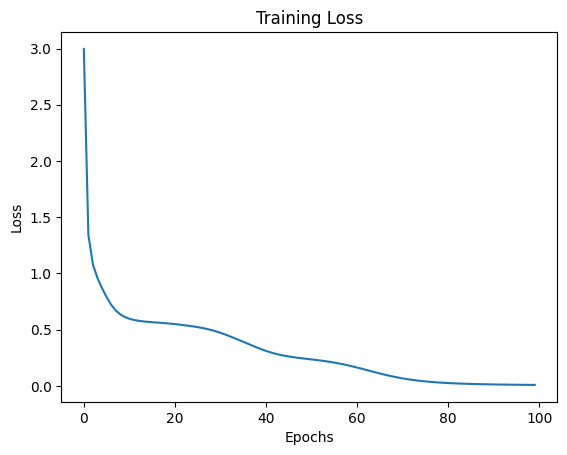

In [ ]:
def plot_train_loss(loss_points):
  plt.plot(loss_points);
  plt.title('Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
plot_train_loss(loss_points);

### **Avaliando a predição**

Para avaliar a predição, usamos o modelo de forma semelhante ao treinamento, mas sem utilizar o Teacher Forcing. Simplesmente realimentamos o decoder com suas próprias predições a cada passo. Quando o decoder produz o token EOS, o processo é interrompido.

In [ ]:
def evaluate(encoder, decoder, sentence):
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
    input_tensor = tensorFromSentence(input_dict, sentence)

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()

    decoded_words = []
    for idx in decoded_ids:
      if idx.item() == EOS_token:
        # decoded_words.append('<EOS>')
        break
      decoded_words.append(output_dict_reverse[idx.item()])
  return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=5):
  for i in range(n):
    pair = random.choice(pairs)
    print(f'Input: {pair[0]}')
    print(f'Ground truth: {pair[1]}')
    output_words, _ = evaluate(encoder, decoder, pair[0])
    output_sentence = ''.join(output_words)
    print(f'Predicted: {output_sentence}')
    print('')

In [ ]:
evaluateRandomly(encoder, decoder)

Input: quinta-feira 20 de outubro de 2022
Ground truth: 20/10/2022
Predicted: 20/2022

Input: quarta-feira 21 de maio de 1986
Ground truth: 21/05/1986
Predicted: 21SOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOS

Input: setembro 13 1987
Ground truth: 13/09/1987
Predicted: SOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOS

Input: 28 ago. 1973
Ground truth: 28/08/1973
Predicted: 28/1973

Input: quarta-feira 3 de agosto de 1988
Ground truth: 03/08/1988
Predicted: 03/1988



----
## 3.  **Adicionando Atenção**

A atenção permite que a rede do decoder "foque" em uma parte diferente das saídas do encoder a cada passo das suas próprias saídas. Primeiro, calculamos um conjunto de pesos de atenção. Esses pesos serão multiplicados pelos vetores de saída do encoder para criar uma combinação ponderada. O resultado (chamado attn_applied no código) deve conter informações sobre aquela parte específica da sequência de entrada e, assim, ajudar o decoder a escolher as palavras corretas na saída.

![](https://i.imgur.com/1152PYf.png)

In [ ]:
# Bahdanau attention, also known as additive attention, is a commonly used
# attention mechanism in sequence-to-sequence models, particularly in
# neural machine translation tasks. It was introduced by Bahdanau et al.
# in their paper titled [Neural Machine Translation by Jointly Learning to
# Align and Translate](https://arxiv.org/pdf/1409.0473.pdf). This
# attention mechanism employs a learned alignment model to compute
# attention scores between the encoder and decoder hidden states. It
# utilizes a feed-forward neural network to calculate alignment scores.

class BahdanauAttention(nn.Module):
  def __init__(self, hidden_size):
    '''Initialize the BahdanauAttention class.

    Parameters:
    - hidden_size: The size of the hidden state used in the attention mechanism.
    '''
    super(BahdanauAttention, self).__init__()
    self.Wa = nn.Linear(hidden_size, hidden_size)
    self.Ua = nn.Linear(hidden_size, hidden_size)
    self.Va = nn.Linear(hidden_size, 1)

  def forward(self, query, keys):
    scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
    scores = scores.squeeze(2).unsqueeze(1)

    weights = F.softmax(scores, dim=-1)
    context = torch.bmm(weights, keys)
    return context, weights  # Return the context vector and attention weights.

In [ ]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p=0.1):
    """
    Initializes the decoding layer (Decoder with Attention) of an RNN.

    Parameters:
    - hidden_size: The size of the hidden state vector.
    - output_size: The size of the output vocabulary (number of unique words in the target language).
    - dropout_p: The dropout probability for regularization during training.
    """
    super(AttnDecoderRNN, self).__init__()

    # Embedding layer transforms word indices into dense vectors of size 'hidden_size'.
    self.embedding = nn.Embedding(output_size, hidden_size)

    # Attention mechanism to compute context vectors from encoder outputs.
    self.attention = BahdanauAttention(hidden_size)

    # GRU layer that processes the combined input of embeddings and context vectors.
    self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)

    # Linear layer maps the GRU output to the output vocabulary space.
    self.out = nn.Linear(hidden_size, output_size)

    # Dropout layer for regularization to prevent overfitting during training.
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    """
    Defines the forward pass for the attention decoder.

    Parameters:
    - encoder_outputs: The output sequences from the encoder (shape: batch_size, seq_len, hidden_size).
    - encoder_hidden: The last hidden state of the encoder (shape: 1, batch_size, hidden_size).
    - target_tensor: The target sequence for teacher forcing (optional).

    Returns:
    - decoder_outputs: The output probabilities (log-softmax) for each time step (shape: batch_size, seq_len, output_size).
    - decoder_hidden: The final hidden state of the decoder (shape: 1, batch_size, hidden_size).
    - attentions: The attention weights for each time step (shape: batch_size, seq_len).
    """
    batch_size = encoder_outputs.size(0)
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []
    attentions = []

    # Loop through each time step to generate the output sequence.
    for i in range(MAX_LENGTH):
      # Call the forward_step function to get output, hidden state, and attention weights for the current time step.
      decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
      decoder_outputs.append(decoder_output)
      attentions.append(attn_weights)

      if target_tensor is not None:
        # Teacher forcing: Feed the target token as the next input to the decoder.
        decoder_input = target_tensor[:, i].unsqueeze(1)
      else:
        # Without teacher forcing: Use its own predictions as the next input.
        _, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze(-1).detach()  # detach from history as input

    # Concatenate all decoder outputs along the time step dimension.
    decoder_outputs = torch.cat(decoder_outputs, dim=1)

    # Apply log softmax to the outputs to get log-probabilities.
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

    # Concatenate all attention weights along the time step dimension.
    attentions = torch.cat(attentions, dim=1)

    # Return the outputs, final hidden state, and attention weights.
    return decoder_outputs, decoder_hidden, attentions


  def forward_step(self, input, hidden, encoder_outputs):
    """
    Processes a single step in the decoding sequence with attention.

    Parameters:
    - input: The current input to the decoder (shape: batch_size, 1).
    - hidden: The current hidden state of the decoder (shape: 1, batch_size, hidden_size).
    - encoder_outputs: The outputs from the encoder (shape: batch_size, seq_len, hidden_size).

    Returns:
    - output: The predicted output (shape: batch_size, 1, output_size).
    - hidden: The updated hidden state (shape: 1, batch_size, hidden_size).
    - attn_weights: The attention weights for the current input (shape: batch_size, seq_len).
    """
    # Get the embedded representation of the current input with dropout for regularization.
    embedded =  self.dropout(self.embedding(input))

    # Permute hidden state to match the query shape for the attention mechanism.
    query = hidden.permute(1, 0, 2)

    # Compute the context vector and attention weights using the attention mechanism.
    context, attn_weights = self.attention(query, encoder_outputs)

    # Concatenate the embedded input and the context vector for the GRU.
    input_gru = torch.cat((embedded, context), dim=2)

    # Pass the combined input through the GRU layer to get the output and updated hidden state.
    output, hidden = self.gru(input_gru, hidden)

    # Map the GRU output to the output vocabulary space using the linear layer.
    output = self.out(output)

    return output, hidden, attn_weights

### Treinando

In [ ]:
hidden_size = 128
batch_size = 1024

train_dataloader = get_dataloader(batch_size, pairs, input_dict, output_dict)

encoder = EncoderRNN(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

# decoder = DecoderRNN(
decoder = AttnDecoderRNN(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points = train(train_dataloader, encoder, decoder, 100, learning_rate=0.001)


Epoch:   10/ 100 - Loss: 0.5882
Epoch:   20/ 100 - Loss: 0.5569
Epoch:   30/ 100 - Loss: 0.5368
Epoch:   40/ 100 - Loss: 0.4517
Epoch:   50/ 100 - Loss: 0.3055
Epoch:   60/ 100 - Loss: 0.1211
Epoch:   70/ 100 - Loss: 0.0225
Epoch:   80/ 100 - Loss: 0.0092
Epoch:   90/ 100 - Loss: 0.0055
Epoch:  100/ 100 - Loss: 0.0038


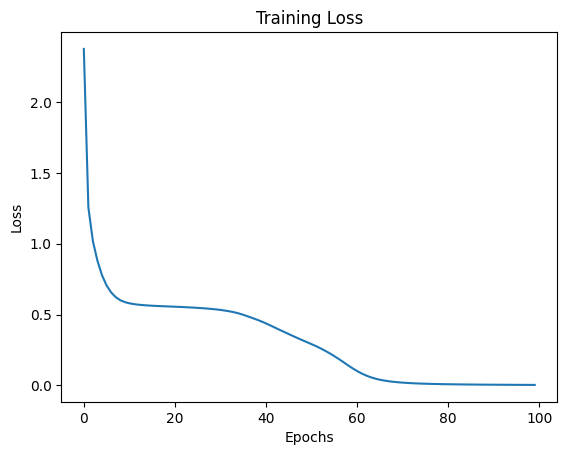

In [ ]:
plot_train_loss(loss_points);

In [ ]:
evaluateRandomly(encoder, decoder)

Input: sabado 14 de dezembro de 2013
Ground truth: 14/12/2013
Predicted: 14/12/2013

Input: 8 fevereiro 1994
Ground truth: 08/02/1994
Predicted: SOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOS

Input: sabado 10 de marco de 2018
Ground truth: 10/03/2018
Predicted: 10/2018

Input: quinta-feira 8 de outubro de 1998
Ground truth: 08/10/1998
Predicted: 08/1998

Input: 14 abril 2003
Ground truth: 14/04/2003
Predicted: 14/04/2003



### **Visualizando as máscaras de Atenção**

Uma propriedade útil do mecanismo de atenção é a alta interpretabilidade de suas saídas. Como ele é usado para atribuir pesos específicos às saídas do encoder da sequência de entrada, podemos imaginar onde a rede está mais focada em cada passo de tempo.

input = 20 de novembro de 2015
output = 20/11/2015


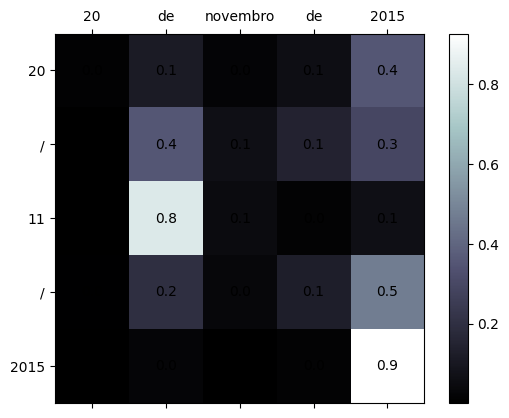

input = 22 de maio 1981
output = 22SOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOSSOS


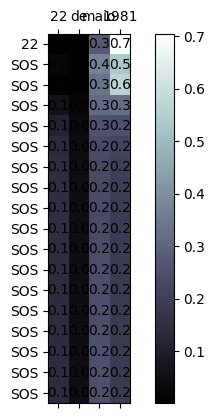

input = 15.11.2013
output = 15/11/2013


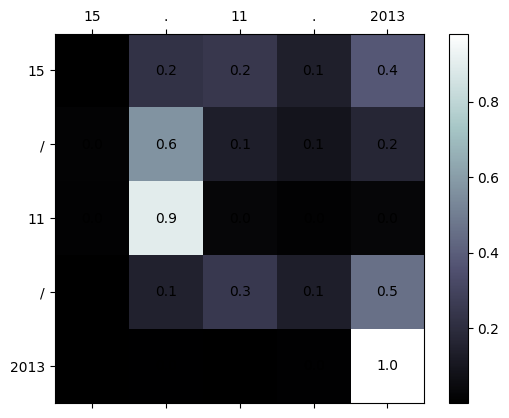

input = 01 de jan. 1989
output = 01/01/1989


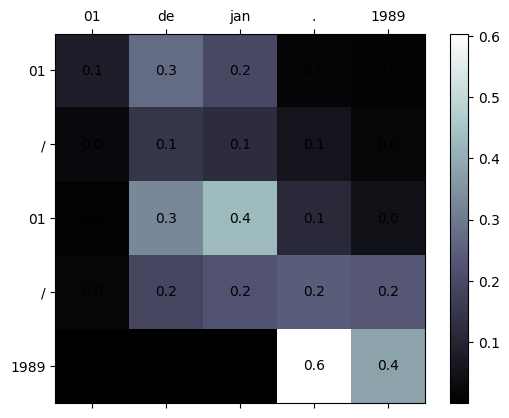

In [ ]:
%matplotlib inline
def showAttention(input_sentence, output_words, attentions):
  fig = plt.figure()
  ax = fig.add_subplot()
  data = attentions.cpu().numpy().squeeze()
  cax = ax.matshow(data, cmap='bone')
  fig.colorbar(cax)

  # Set up axes
  input_tokens = [token for token in re.split('([^a-zA-Z0-9])', input_sentence) if token.strip()]
  ax.set_xticks(ticks=range(len(input_tokens)), labels=input_tokens)
  ax.set_yticks(ticks=range(len(output_words)), labels=output_words)

  # Show label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

  plt.show()


def evaluateAndShowAttention(input_sentence):
  output_words, attentions = evaluate(encoder, decoder, input_sentence)
  print('input =', input_sentence)
  print('output =', ''.join(output_words))
  showAttention(input_sentence, output_words, attentions[0, :len(output_words), 1:])
  plt.show()



evaluateAndShowAttention('20 de novembro de 2015')

evaluateAndShowAttention('22 de maio 1981')

evaluateAndShowAttention('15.11.2013')

evaluateAndShowAttention('01 de jan. 1989')

----
##  4. **Exercícios de Exploração Sugeridos**

1. **Experimentar com outros datasets:**
   - Tente utilizar um dataset diferente para observar como o modelo se comporta com dados novos. Algumas sugestões incluem:
     - **Outro par de idiomas**: Experimente traduzir entre diferentes idiomas para testar a flexibilidade do modelo Seq2Seq.
     - **Chat → Resposta**: Utilize um dataset de conversas e explore o mapeamento de mensagens para respostas.
     - **Pergunta → Resposta**: Experimente um dataset de perguntas e respostas, onde o modelo aprende a fornecer respostas a perguntas específicas.

2. **Explorar codificações alternativas:**
   - Em vez de utilizar representações simples de palavras, tente usar **embeddings de palavras**. Isso pode melhorar a capacidade do modelo de capturar relacionamentos semânticos entre as palavras. Exemplos incluem: **Word2Vec** ou **GloVe**: Substitua as embeddings atuais por embeddings pré-treinadas para aproveitar o conhecimento adicional aprendido em grandes corpora.
   - Experimente outras maneiras de **tokenizar o dataset**. Por exemplo, você pode usar subpalavras (como BPE - Byte Pair Encoding) ou tokens baseados em caracteres em vez de palavras inteiras.

3. **Ajustes na arquitetura do modelo:**
   - **Aumentar a complexidade do modelo**: Tente aumentar o número de camadas, o número de unidades ocultas (*hidden units*) e experimente treinar com sentenças mais longas. Compare o tempo de treinamento e a qualidade dos resultados obtidos. Isso pode revelar como o modelo escala com a complexidade.
   - Em vez de utilizar células GRU, tente implementar o modelo com células **LSTM**. Compare os resultados e observe as diferenças no tempo de convergência e na qualidade da tradução.

   - **Treinamento de um autoencoder**:
     - Use um arquivo de tradução em que as frases de entrada e saída sejam idênticas (exemplo: "Eu sou um teste \t Eu sou um teste").
     - Treine o modelo como um **autoencoder**.
     - Após o treinamento, **salve apenas a rede Encoder** e, em seguida, treine um novo Decoder para realizar a tradução a partir das representações do Encoder.

4. **Explorar diferentes mecanismos de atenção:**
   - Tente usar outro tipo de **mecanismo de atenção** (como **multi-head attention**) e compare os resultados em termos de precisão e capacidade de generalização.

5. **Revisão e Contribuição:**
   - Como o notebook não foi extensivamente testado, sinta-se à vontade para procurar e corrigir quaisquer erros que encontrar. Agradecemos qualquer contribuição para melhorar o código e a documentação. Seu feedback é valioso para aprimorar a experiência de aprendizado para todos os alunos.

...




---



# EP 3 - Implementações e discussões

De modo a ter mais liberdade para mexer no encoder e no decoder, optei por experimentar utilizando modelos de tradução. Para isto, tomei como principal referência o tutorial do pytorch: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html que já havia sido recomendado como uma referência na elaboração do EP. Além disso, como o próprio site recomenda, utilizei o site https://www.manythings.org/anki/ para baixar o dataset de tradução já tratado. Neste site estão dispostas várias traduções para inglês. Aqui estaremos usando o dataset de tradução português <-> inglês. Utilizei duas tentativas: usando o mesmo método descrito já anteriormente, mas com algumas adaptações por serem palavras e o método descrito pelo tutorial do pytorch. Dentro de ambos os métodos, brinquei com alguns detalhes extras para tentar entender melhor como cada um funciona.

## Adaptando o modelo do EP:

In [ ]:
import random
import re
import time
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import gdown

plt.switch_backend('agg')
%matplotlib inline

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device={device}')

device=cuda


Tipo do dataset:
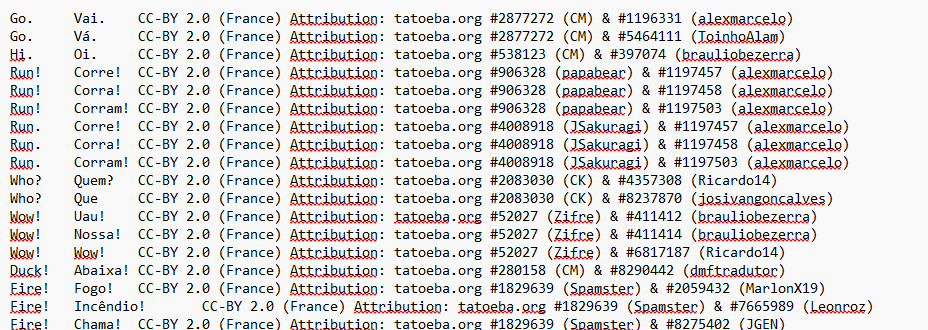

In [ ]:
def readDataset(reverse=False): #Utilizando um link online para realizar puxar o dataset
  url = 'https://drive.google.com/uc?id=1Dt96VaplAImAPwJP1-FjHZQiP-0Tcvi1'
  file = 'por.txt'
  gdown.download(url, file, quiet=False)
  lines = open(file, encoding='utf-8').read().strip().split('\n') #abrindo cada linha
  pairs = [[s for s in l.split('\t')[:2]] for l in lines] #tomando apenas os dois primeiros itens que se trata da real informação
  print()
  print(f'Read {len(pairs)} samples from {file}')
  print()
  print("\n".join(map(str, random.sample(pairs, 15))))
  return  pairs

pairs = readDataset()

Downloading...
From: https://drive.google.com/uc?id=1Dt96VaplAImAPwJP1-FjHZQiP-0Tcvi1
To: /content/por.txt
100%|██████████| 28.3M/28.3M [00:00<00:00, 93.7MB/s]



Read 193633 samples from por.txt

['The further we are from one disaster, the closer we are to the next.', 'Quanto mais longe estamos de um desastre, mais perto estamos do próximo.']
["I'm not going to ask again.", 'Eu não vou pedir novamente.']
['What am I to do?', 'O que eu devo fazer?']
['What did Tom think?', 'O que Tom achou?']
['Tom planted some flower seeds in his garden.', 'Tom plantou algumas sementes de flores em seu jardim.']
['Nobody is here.', 'Não há ninguém aqui.']
["I'm not doing this for you.", 'Não estou fazendo isso por você.']
["That's something I can't control.", 'Isso é algo que não posso controlar.']
['You should be brief.', 'Você deveria ser breve.']
['Where are the sandwiches?', 'Cadê os sanduíches?']
['Deposit your money in the bank.', 'Deposite o seu dinheiro no banco.']
['Please remain standing.', 'Por favor, permaneçam de pé.']
['Get a ticket for me.', 'Pega um ingresso para mim.']
['No one saw anything.', 'Ninguém viu nada.']
["Tom said that he thought he

Para facilitar o treinamento sem cair o kernel, vamos tomar uma restrição da amostra:

In [ ]:
sample_size = int(input("Digite o tamanho da amostra: "))
print(f"Amostra de tamanho {sample_size} criada")
sampled_pairs = random.sample(pairs, sample_size)

Digite o tamanho da amostra: 10000
Amostra de tamanho 10000 criada


Agora, iremos separar cada par na palavra de input (inglês) e output (português) e incluir os tokens de SOS - Start of Sentence, EOS - End of Sentence e um token para os espaços entre as palavras. Faço isso pois, nas primeiras vezes que rodei o código, os outputs apresentavam resultado sem nenhum espaço entre as palavras. Adicionar o token de espaço ajudou muito neste problema. Além disso, adicionamos o modo "reverse" para caso queiramos treinar a tradução de português para inglês.

In [ ]:
SOS_token = 0
EOS_token = 1
space_token = 2


def prepareData(pairs):
  input_dict  = {"SOS": SOS_token, "EOS": EOS_token, " ": space_token}
  output_dict = {"SOS": SOS_token, "EOS": EOS_token, " ": space_token}

  input_dict_reverse  = {SOS_token: "SOS", EOS_token: "EOS", " ": space_token}
  output_dict_reverse = {SOS_token: "SOS", EOS_token: "EOS", " ": space_token}

  for pair in pairs:
    ipt, tgt = pair

    mask = '([^a-zA-Z0-9])' #para tirar todos os inputs que não sejam letras ou números e separar acentos
    result = [token for token in re.split(mask, ipt) if token.strip()]
    for word_input in result:
      if word_input not in input_dict:
        next_int = max(input_dict.values()) + 1
        input_dict[word_input] = next_int
        input_dict_reverse[next_int] = word_input

    for word_output in re.split(mask, tgt):
      if word_output not in output_dict:
        next_int = max(output_dict.values()) + 1
        output_dict[word_output] = next_int
        output_dict_reverse[word_output] = word_output

  print(f'Number of input words: {len(input_dict.keys())}')
  print(f'Number of output words: {len(output_dict.keys())}')

  return input_dict, output_dict, input_dict_reverse, output_dict_reverse

input_dict, output_dict, input_dict_reverse, output_dict_reverse = prepareData(sampled_pairs)

Number of input words: 4577
Number of output words: 6421


Estamos primeiro utilizando o indexes from sentences para fazer o embeding das palavras. Neste caso, veja que cada palavra recebe um número associado na lista, seguindo a ordem do dicionário a que está atribuída. Por tal motivo que os espaços são numerados por 2. Neste caso, estamos fazendo como um OneHotEmbedding, separando as palavras em tokens menores (como o There's vira There + ' + s e enumerando a cada um em uma lista)

In [ ]:
def indexesFromSentence(language_dict, sentence, verbose=False):
  '''
    Função utilitária para converter uma sentença em índices
  '''
  encoded = []
  for word in re.split('([^a-zA-Z0-9])', sentence):
    if word.strip():
      encoded.append(language_dict.get(word, language_dict[' ']))
    elif word == ' ':
      encoded.append(language_dict[' '])
  if verbose:
    print(f"'{sentence}' => {encoded}")
  return encoded

indexesFromSentence(input_dict, "There's nothing left to worry about.", verbose=True);
indexesFromSentence(output_dict, 'Eu acredito que você gosta do seu trabalho', verbose=True);

'There's nothing left to worry about.' => [377, 21, 126, 2, 290, 2, 130, 2, 51, 2, 135, 2, 63, 9]
'Eu acredito que você gosta do seu trabalho' => [21, 2, 1715, 2, 23, 2, 74, 75, 2, 77, 2, 138, 2, 333, 2, 1019]


In [ ]:
print(input_dict_reverse[377])
print(input_dict_reverse[21])
print(input_dict_reverse[126])
print(input_dict_reverse[377]+input_dict_reverse[21]+input_dict_reverse[126])

There
'
s
There's


Agora, com o TensorFromSentence vamos adicionar o token de SOS e EOS, transformando-os também em tensores para abastecer o DataLoader

In [ ]:
# Funções utilitárias
def tensorFromSentence(language_dict, sentence):
  indexes = indexesFromSentence(language_dict, sentence)
  indexes.insert(0, SOS_token)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_dict, pair[0])
    target_tensor = tensorFromSentence(output_dict, pair[1])
    return (input_tensor, target_tensor)

sample = random.sample(sampled_pairs, 1)
ipt, out = sample[0]
print(f'Input: {ipt}')
print(f'Output: {out}')
tensorsFromPair([ipt,out])

Input: It hurts here.
Output: Dói-me aqui.


(tensor([[   0,  211,    2, 4004,    2,   32,    9,    1]], device='cuda:0'),
 tensor([[   0,  516,   52, 4211,  132,  133,    2,   62,   11,    1]],
        device='cuda:0'))

##### Testando com MAX_LENGTH = 18

In [ ]:
MAX_LENGTH = 18 #definindo um Max_length - qual a influência dele aqui? Entendo que seja o tamanho da frase, mas o quão irá influenciar no treinamento?

In [ ]:
def get_dataloader(batch_size, pairs, input_dict, output_dict):
  n = len(pairs)
  input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
  target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

  for idx, (inp, tgt) in enumerate(pairs):
    inp_ids = indexesFromSentence(input_dict, inp)
    tgt_ids = indexesFromSentence(output_dict, tgt)
    inp_ids.append(EOS_token)
    tgt_ids.append(EOS_token)
    input_ids[idx, :min(len(inp_ids), MAX_LENGTH)] = inp_ids[:MAX_LENGTH]
    target_ids[idx, :min(len(tgt_ids), MAX_LENGTH)] = tgt_ids[:MAX_LENGTH]

  train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))

  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  return train_dataloader

In [ ]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size, dropout_p=0.1):
    """
    Initializes the encoding layer (Encoder) of an RNN.

    Parameters:
    - input_size: The number of expected features in the input x
    - hidden_size: The number of features in the hidden state h
    - dropout_p: If non-zero, introduces a Dropout layer on the outputs of each GRU layer except the last layer
    """
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    # Embedding layer that transforms word indices into dense vectors of size 'hidden_size'.
    self.embedding = nn.Embedding(input_size, hidden_size)

    # Defines the GRU (Gated Recurrent Unit) with both input and output dimensions of 'hidden_size'.
    # 'batch_first=True' indicates that the first input dimension is the batch (batch_size, seq_len, hidden_size).
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    # Dropout applied after the embedding layer to prevent overfitting.
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, input):
    """
    Defines the forward pass of the model.

    Parameter:
    - input: Sequence of word indices of size (batch_size, seq_len).

    Returns:
    - output: GRU outputs for each step in the sequence (batch_size, seq_len, hidden_size).
    - hidden: The last hidden state vector of the GRU (1, batch_size, hidden_size).
        """
    embedded = self.dropout(self.embedding(input))
    output, hidden = self.gru(embedded)
    return output, hidden

In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    """
    Initializes the decoding layer (Decoder) of an RNN.

    Parameters:
    - hidden_size: The size of the hidden state vector.
    - output_size: The size of the output vocabulary (number of unique words in the target language).
    """
    super(DecoderRNN, self).__init__()

    # Embedding layer that transforms word indices into dense vectors of size 'hidden_size'.
    self.embedding = nn.Embedding(output_size, hidden_size)

    # Defines a GRU layer that processes input sequences. Both input and output dimensions are 'hidden_size'.
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    # Linear layer that maps the hidden state of the GRU to the output vocabulary space.
    self.out = nn.Linear(hidden_size, output_size)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor):
    """
    Defines the forward pass for the decoder.

    Parameters:
    - encoder_outputs: The output sequence from the encoder (batch_size, seq_len, hidden_size).
    - encoder_hidden: The last hidden state of the encoder (1, batch_size, hidden_size).
    - target_tensor: The target sequence for teacher forcing (optional).

    Returns:
    - decoder_outputs: The output probabilities (log-softmax) for each time step (batch_size, seq_len, output_size).
    - decoder_hidden: The final hidden state of the decoder (1, batch_size, hidden_size).
    - None: Placeholder for consistency with other methods (e.g., attention).
    """
    batch_size = encoder_outputs.size(0)

    # Initial decoder input is the <SOS> token for every sequence in the batch.
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []

    # Loop through each time step
    for i in range(MAX_LENGTH):
      # Call the forward_step function to get output and hidden state for the current time step.
      decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
      decoder_outputs.append(decoder_output)

      if target_tensor is not None:
        # Teacher forcing: Use the target token as the next input to the decoder.
        decoder_input = target_tensor[:, i].unsqueeze(1)
      else:
        # Without teacher forcing: use its own predictions as the next input
        _, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze(-1).detach()

    # Concatenate all the decoder outputs along the time step dimension.
    decoder_outputs = torch.cat(decoder_outputs, dim=1)

    # Apply log softmax to the outputs to get log-probabilities.
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

    # Return the outputs, final hidden state, and `None` (for consistency with attention models implemented next).
    return decoder_outputs, decoder_hidden, None

  def forward_step(self, input, hidden):
    """
    Processes a single step in the decoding sequence.

    Parameters:
    - input: The current input to the decoder (batch_size, 1).
    - hidden: The current hidden state of the decoder (1, batch_size, hidden_size).

    Returns:
    - output: The predicted output (batch_size, 1, output_size).
    - hidden: The updated hidden state (1, batch_size, hidden_size).
    """
    output = self.embedding(input)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.out(output)
    return output, hidden

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
  """
  Train the encoder and decoder for one epoch.

  Parameters:
  - dataloader: Iterable that provides batches of input and target tensors.
  - encoder: The encoder model.
  - decoder: The decoder model.
  - encoder_optimizer: Optimizer for updating the encoder's parameters.
  - decoder_optimizer: Optimizer for updating the decoder's parameters.
  - criterion: Loss function to measure the difference between the predicted and target outputs.

  Returns:
  - The average loss over the epoch.
  """
  total_loss = 0
  for data in dataloader:
    input_tensor, target_tensor = data

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor=None)

    loss = criterion(
        decoder_outputs.view(-1, decoder_outputs.size(-1)),
        target_tensor.view(-1)
    )
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001):
  loss_points = []

  plot_losses = []
  print_loss_total = 0  # Reset every print_every
  plot_loss_total = 0  # Reset every plot_every

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  criterion = nn.NLLLoss()

  for epoch in range(1, n_epochs + 1):
    loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    loss_points.append(loss)

    if epoch % 10 == 0:
      print(f'Epoch: {epoch:4}/{n_epochs:4} - Loss: {loss:.4f}')


  return loss_points


In [ ]:
hidden_size = 128
batch_size = 1024

train_dataloader = get_dataloader(batch_size, sampled_pairs, input_dict, output_dict)

encoder = EncoderRNN(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

decoder = DecoderRNN(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points = train(train_dataloader, encoder, decoder, 300, learning_rate=0.001)


Epoch:   10/ 300 - Loss: 3.2391
Epoch:   20/ 300 - Loss: 3.0694
Epoch:   30/ 300 - Loss: 2.9610
Epoch:   40/ 300 - Loss: 2.8528
Epoch:   50/ 300 - Loss: 2.7015
Epoch:   60/ 300 - Loss: 2.5136
Epoch:   70/ 300 - Loss: 2.3999
Epoch:   80/ 300 - Loss: 2.3074
Epoch:   90/ 300 - Loss: 2.2233
Epoch:  100/ 300 - Loss: 2.1413
Epoch:  110/ 300 - Loss: 2.0741
Epoch:  120/ 300 - Loss: 2.0055
Epoch:  130/ 300 - Loss: 1.9429
Epoch:  140/ 300 - Loss: 1.8883
Epoch:  150/ 300 - Loss: 1.8334
Epoch:  160/ 300 - Loss: 1.7802
Epoch:  170/ 300 - Loss: 1.7250
Epoch:  180/ 300 - Loss: 1.6836
Epoch:  190/ 300 - Loss: 1.6307
Epoch:  200/ 300 - Loss: 1.5873
Epoch:  210/ 300 - Loss: 1.5509
Epoch:  220/ 300 - Loss: 1.5021
Epoch:  230/ 300 - Loss: 1.4590
Epoch:  240/ 300 - Loss: 1.4264
Epoch:  250/ 300 - Loss: 1.3927
Epoch:  260/ 300 - Loss: 1.3541
Epoch:  270/ 300 - Loss: 1.3226
Epoch:  280/ 300 - Loss: 1.2937
Epoch:  290/ 300 - Loss: 1.2553
Epoch:  300/ 300 - Loss: 1.2412


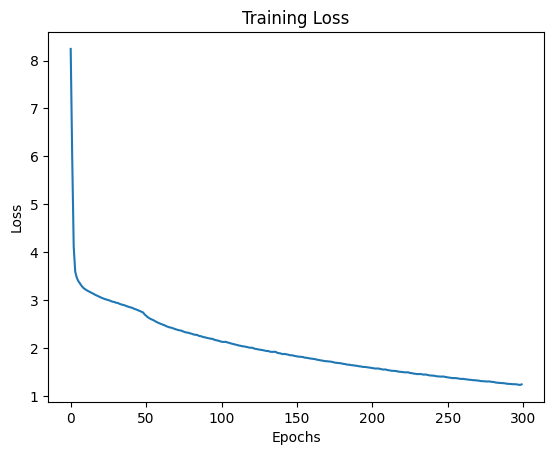

In [ ]:
def plot_train_loss(loss_points):
  plt.plot(loss_points);
  plt.title('Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
plot_train_loss(loss_points);

In [ ]:
def evaluate(encoder, decoder, sentence):
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
    input_tensor = tensorFromSentence(input_dict, sentence)

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden, target_tensor=None)

    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()

    decoded_words = []
    for idx in decoded_ids:
        # Obter a palavra correspondente ao índice
        # (assumindo que output_dict contém {palavra: índice})

        # Se seu output_dict_reverse for {index: palavra}:
        # word = output_dict_reverse.get(idx.item(), "<UNK>")

        # Se seu output_dict_reverse for {palavra: index} e você tiver o output_dict:
        word = next((word for word, index in output_dict.items() if index == idx.item()), "<UNK>")


        # Verificar se a palavra está no output_dict_reverse
        # (assumindo que output_dict_reverse contém {palavra: índice_reverso})
        # Esse if é apenas para segurança adicional, mas na realidade
        # se a palavra estiver no output_dict, deverá ter uma entrada correspondente
        # no output_dict_reverse. Se isso não estiver ocorrendo o problema esta na
        # criação do output_dict_reverse
        if word in output_dict_reverse:
            decoded_words.append(word)
        else:
            print(f"Palavra não encontrada em output_dict_reverse: {word}")
            decoded_words.append("<UNK>")

        if idx.item() == EOS_token:
            break
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=5):
  for i in range(n):
    pair = random.choice(sampled_pairs)
    print(f'Input: {pair[0]}')
    print(f'Ground truth: {pair[1]}')
    output_words, _ = evaluate(encoder, decoder, pair[0])
    output_sentence = ''.join(output_words)
    print(f'Predicted: {output_sentence}')
    print('')

In [ ]:
evaluateRandomly(encoder, decoder)

Input: You haven't eaten anything.
Ground truth: Você não comeu nada.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Você    o o     <UNK>

Input: I didn't think that I'd be lonely.
Ground truth: Eu não pensei que ficaria sozinha.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Eu o n o que o <UNK>

Input: Did you buy some potatoes?
Ground truth: Você comprou batatas?
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Por que      ??<UNK>

Input: You can't say no.
Ground truth: Você não pode dizer não.
Predicted: Você    não         

Input: They went to Australia, didn't they?
Ground truth: Elas foram para a Austrália, não foram?
Predicted: Eles não estavam amanh    não o



##### Testando com MAX_LENGTH = 70

In [ ]:
MAX_LENGTH = 70 #definindo um Max_length - qual a influência dele aqui? Entendo que seja o tamanho da frase, mas o quão irá influenciar no treinamento?

In [ ]:
hidden_size = 128
batch_size = 1024

train_dataloader = get_dataloader(batch_size, sampled_pairs, input_dict, output_dict)

encoder = EncoderRNN(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

decoder = DecoderRNN(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points = train(train_dataloader, encoder, decoder, 300, learning_rate=0.001)

Epoch:   10/ 300 - Loss: 3.2933
Epoch:   20/ 300 - Loss: 3.0909
Epoch:   30/ 300 - Loss: 2.9595
Epoch:   40/ 300 - Loss: 2.8385
Epoch:   50/ 300 - Loss: 2.7127
Epoch:   60/ 300 - Loss: 2.4774
Epoch:   70/ 300 - Loss: 2.3523
Epoch:   80/ 300 - Loss: 2.2495
Epoch:   90/ 300 - Loss: 2.1575
Epoch:  100/ 300 - Loss: 2.0821
Epoch:  110/ 300 - Loss: 2.0144
Epoch:  120/ 300 - Loss: 1.9441
Epoch:  130/ 300 - Loss: 1.8868
Epoch:  140/ 300 - Loss: 1.8313
Epoch:  150/ 300 - Loss: 1.7751
Epoch:  160/ 300 - Loss: 1.7190
Epoch:  170/ 300 - Loss: 1.6728
Epoch:  180/ 300 - Loss: 1.6118
Epoch:  190/ 300 - Loss: 1.5707
Epoch:  200/ 300 - Loss: 1.5204
Epoch:  210/ 300 - Loss: 1.4817
Epoch:  220/ 300 - Loss: 1.4412
Epoch:  230/ 300 - Loss: 1.3987
Epoch:  240/ 300 - Loss: 1.3633
Epoch:  250/ 300 - Loss: 1.3298
Epoch:  260/ 300 - Loss: 1.2908
Epoch:  270/ 300 - Loss: 1.2550
Epoch:  280/ 300 - Loss: 1.2270
Epoch:  290/ 300 - Loss: 1.1903
Epoch:  300/ 300 - Loss: 1.1641


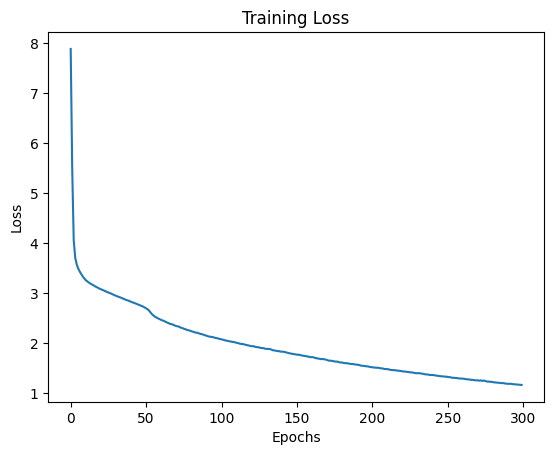

In [ ]:
plot_train_loss(loss_points)

In [ ]:
evaluateRandomly(encoder, decoder)

Input: I miss the army.
Ground truth: Sinto falta do exército.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Eu gosto a cedo a o o o.<UNK>

Input: I wonder if Tom is still confused.
Ground truth: Eu me pergunto se o Tom ainda está confuso.
Predicted: Me pergunto pergunto Tom Tom Tom Tom     

Input: My left foot is asleep.
Ground truth: Meu pé esquerdo adormeceu.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Meu pai  á de      .<UNK>

Input: There's nothing under the chair.
Ground truth: Não tem nada debaixo da cadeira.
Predicted: Não existe a a  ent ent o o

Input: What'll Tom do?
Ground truth: O que Tom fará?
Palavra não encontrada em output_dict_reverse: EOS
Predicted: O que você        o?<UNK>



In [ ]:
hidden_size = 128
batch_size = 32

train_dataloader = get_dataloader(batch_size, sampled_pairs, input_dict, output_dict)

encoder = EncoderRNN(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

decoder = DecoderRNN(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points = train(train_dataloader, encoder, decoder, 100, learning_rate=0.001)

Epoch:   10/ 100 - Loss: 0.6521
Epoch:   20/ 100 - Loss: 0.5451
Epoch:   30/ 100 - Loss: 0.4803
Epoch:   40/ 100 - Loss: 0.4354
Epoch:   50/ 100 - Loss: 0.3960
Epoch:   60/ 100 - Loss: 0.3670
Epoch:   70/ 100 - Loss: 0.3367
Epoch:   80/ 100 - Loss: 0.3139
Epoch:   90/ 100 - Loss: 0.2938
Epoch:  100/ 100 - Loss: 0.2756


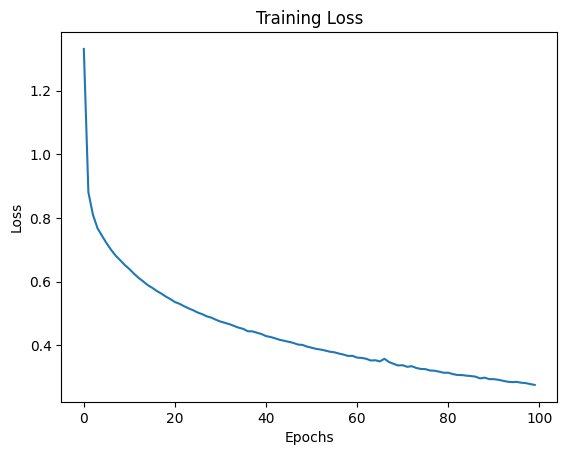

In [ ]:
def plot_train_loss(loss_points):
  plt.plot(loss_points);
  plt.title('Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
plot_train_loss(loss_points)

In [ ]:
evaluateRandomly(encoder, decoder)

Input: Your birthday is coming soon.
Ground truth: O seu aniversário está chegando.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: O seu nome          <UNK>

Input: His chances of being elected are good.
Ground truth: Ele tem boas chances de ser eleito.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: A poss    matou de antes.<UNK>

Input: This is my younger sister.
Ground truth: Esta é a minha irmã caçula.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Esse homem chap chap, perna <UNK>

Input: Do you like this tie?
Ground truth: Você gosta dessa gravata?
Palavra não encontrada em output_dict_reverse: EOS
Predicted: O projeto faz?<UNK>

Input: Tom couldn't help smiling.
Ground truth: Tom não conseguia parar de sorrir.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Tom Tom n o ningu ajuda.<UNK>



Mesmo diminuíndo o erro progressivamente, podemos ver pelas previsões que ainda estamos tendo resultados bem ruins, melhores em comparação ao MAX_LENGTH menos, mas ainda assim sem bater com o Ground truth..

#### E se eu tentar teacher reinforcing?

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
  """
  Train the encoder and decoder for one epoch.

  Parameters:
  - dataloader: Iterable that provides batches of input and target tensors.
  - encoder: The encoder model.
  - decoder: The decoder model.
  - encoder_optimizer: Optimizer for updating the encoder's parameters.
  - decoder_optimizer: Optimizer for updating the decoder's parameters.
  - criterion: Loss function to measure the difference between the predicted and target outputs.

  Returns:
  - The average loss over the epoch.
  """
  total_loss = 0
  for data in dataloader:
    input_tensor, target_tensor = data

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

    loss = criterion(
        decoder_outputs.view(-1, decoder_outputs.size(-1)),
        target_tensor.view(-1)
    )
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
hidden_size = 128
batch_size = 1024

train_dataloader = get_dataloader(batch_size, sampled_pairs, input_dict, output_dict)

encoder = EncoderRNN(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

decoder = DecoderRNN(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points = train(train_dataloader, encoder, decoder, 300, learning_rate=0.001)


Epoch:   10/ 300 - Loss: 2.6306
Epoch:   20/ 300 - Loss: 2.2699
Epoch:   30/ 300 - Loss: 2.0531
Epoch:   40/ 300 - Loss: 1.8626
Epoch:   50/ 300 - Loss: 1.7031
Epoch:   60/ 300 - Loss: 1.5737
Epoch:   70/ 300 - Loss: 1.4686
Epoch:   80/ 300 - Loss: 1.3774
Epoch:   90/ 300 - Loss: 1.2916
Epoch:  100/ 300 - Loss: 1.2100
Epoch:  110/ 300 - Loss: 1.1299
Epoch:  120/ 300 - Loss: 1.0555
Epoch:  130/ 300 - Loss: 0.9851
Epoch:  140/ 300 - Loss: 0.9209
Epoch:  150/ 300 - Loss: 0.8618
Epoch:  160/ 300 - Loss: 0.8074
Epoch:  170/ 300 - Loss: 0.7580
Epoch:  180/ 300 - Loss: 0.7125
Epoch:  190/ 300 - Loss: 0.6696
Epoch:  200/ 300 - Loss: 0.6305
Epoch:  210/ 300 - Loss: 0.5958
Epoch:  220/ 300 - Loss: 0.5636
Epoch:  230/ 300 - Loss: 0.5333
Epoch:  240/ 300 - Loss: 0.5054
Epoch:  250/ 300 - Loss: 0.4802
Epoch:  260/ 300 - Loss: 0.4563
Epoch:  270/ 300 - Loss: 0.4324
Epoch:  280/ 300 - Loss: 0.4131
Epoch:  290/ 300 - Loss: 0.3932
Epoch:  300/ 300 - Loss: 0.3739


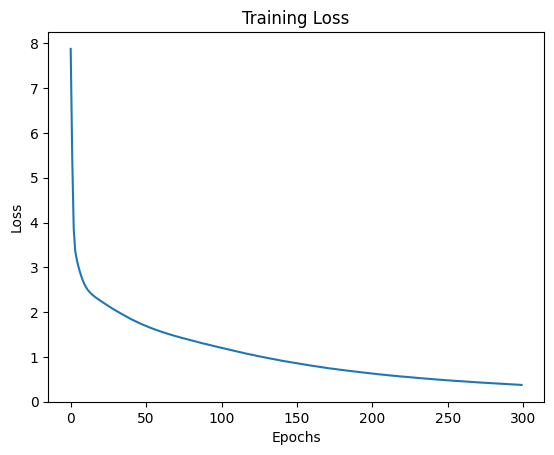

In [ ]:
plot_train_loss(loss_points);

In [ ]:
evaluateRandomly(encoder, decoder)

Input: Tom became nervous.
Ground truth: Tom ficou nervoso.
Predicted: Tom continuou a oferta, não gosta o dia

Input: Do we have to do all that?
Ground truth: Temos que fazer tudo isso?
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Você tem que fazer isso?<UNK>

Input: You are our new neighbor.
Ground truth: Você é nosso novo vizinho.
Predicted: Você é alérgico a diferença, nã

Input: I think he was speaking Latin.
Ground truth: Acho que ele estava falando latim.
Predicted: Acho que ele precisa tentar beijar mas o Tom,

Input: Aren't you retired?
Ground truth: Você não está aposentada?
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Tom não sabe essa pergunta?<UNK>



Nesse caso podemos ver que houve uma melhoria no sentido de que ao menos algumas palavras do Ground truth aparecendo e nestes exemplos não tivemos nenhum caso de começar a delirar.

### Com Bahdanau attention

In [ ]:
# Bahdanau attention, also known as additive attention, is a commonly used
# attention mechanism in sequence-to-sequence models, particularly in
# neural machine translation tasks. It was introduced by Bahdanau et al.
# in their paper titled [Neural Machine Translation by Jointly Learning to
# Align and Translate](https://arxiv.org/pdf/1409.0473.pdf). This
# attention mechanism employs a learned alignment model to compute
# attention scores between the encoder and decoder hidden states. It
# utilizes a feed-forward neural network to calculate alignment scores.

class BahdanauAttention(nn.Module):
  def __init__(self, hidden_size):
    '''Initialize the BahdanauAttention class.

    Parameters:
    - hidden_size: The size of the hidden state used in the attention mechanism.
    '''
    super(BahdanauAttention, self).__init__()
    self.Wa = nn.Linear(hidden_size, hidden_size)
    self.Ua = nn.Linear(hidden_size, hidden_size)
    self.Va = nn.Linear(hidden_size, 1)

  def forward(self, query, keys):
    scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
    scores = scores.squeeze(2).unsqueeze(1)

    weights = F.softmax(scores, dim=-1)
    context = torch.bmm(weights, keys)
    return context, weights  # Return the context vector and attention weights.

In [ ]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p=0.1):
    """
    Initializes the decoding layer (Decoder with Attention) of an RNN.

    Parameters:
    - hidden_size: The size of the hidden state vector.
    - output_size: The size of the output vocabulary (number of unique words in the target language).
    - dropout_p: The dropout probability for regularization during training.
    """
    super(AttnDecoderRNN, self).__init__()

    # Embedding layer transforms word indices into dense vectors of size 'hidden_size'.
    self.embedding = nn.Embedding(output_size, hidden_size)

    # Attention mechanism to compute context vectors from encoder outputs.
    self.attention = BahdanauAttention(hidden_size)

    # GRU layer that processes the combined input of embeddings and context vectors.
    self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)

    # Linear layer maps the GRU output to the output vocabulary space.
    self.out = nn.Linear(hidden_size, output_size)

    # Dropout layer for regularization to prevent overfitting during training.
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    """
    Defines the forward pass for the attention decoder.

    Parameters:
    - encoder_outputs: The output sequences from the encoder (shape: batch_size, seq_len, hidden_size).
    - encoder_hidden: The last hidden state of the encoder (shape: 1, batch_size, hidden_size).
    - target_tensor: The target sequence for teacher forcing (optional).

    Returns:
    - decoder_outputs: The output probabilities (log-softmax) for each time step (shape: batch_size, seq_len, output_size).
    - decoder_hidden: The final hidden state of the decoder (shape: 1, batch_size, hidden_size).
    - attentions: The attention weights for each time step (shape: batch_size, seq_len).
    """
    batch_size = encoder_outputs.size(0)
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []
    attentions = []

    # Loop through each time step to generate the output sequence.
    for i in range(MAX_LENGTH):
      # Call the forward_step function to get output, hidden state, and attention weights for the current time step.
      decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
      decoder_outputs.append(decoder_output)
      attentions.append(attn_weights)

      if target_tensor is not None:
        # Teacher forcing: Feed the target token as the next input to the decoder.
        decoder_input = target_tensor[:, i].unsqueeze(1)
      else:
        # Without teacher forcing: Use its own predictions as the next input.
        _, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze(-1).detach()  # detach from history as input

    # Concatenate all decoder outputs along the time step dimension.
    decoder_outputs = torch.cat(decoder_outputs, dim=1)

    # Apply log softmax to the outputs to get log-probabilities.
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

    # Concatenate all attention weights along the time step dimension.
    attentions = torch.cat(attentions, dim=1)

    # Return the outputs, final hidden state, and attention weights.
    return decoder_outputs, decoder_hidden, attentions


  def forward_step(self, input, hidden, encoder_outputs):
    """
    Processes a single step in the decoding sequence with attention.

    Parameters:
    - input: The current input to the decoder (shape: batch_size, 1).
    - hidden: The current hidden state of the decoder (shape: 1, batch_size, hidden_size).
    - encoder_outputs: The outputs from the encoder (shape: batch_size, seq_len, hidden_size).

    Returns:
    - output: The predicted output (shape: batch_size, 1, output_size).
    - hidden: The updated hidden state (shape: 1, batch_size, hidden_size).
    - attn_weights: The attention weights for the current input (shape: batch_size, seq_len).
    """
    # Get the embedded representation of the current input with dropout for regularization.
    embedded =  self.dropout(self.embedding(input))

    # Permute hidden state to match the query shape for the attention mechanism.
    query = hidden.permute(1, 0, 2)

    # Compute the context vector and attention weights using the attention mechanism.
    context, attn_weights = self.attention(query, encoder_outputs)

    # Concatenate the embedded input and the context vector for the GRU.
    input_gru = torch.cat((embedded, context), dim=2)

    # Pass the combined input through the GRU layer to get the output and updated hidden state.
    output, hidden = self.gru(input_gru, hidden)

    # Map the GRU output to the output vocabulary space using the linear layer.
    output = self.out(output)

    return output, hidden, attn_weights

In [ ]:
hidden_size = 128
batch_size = 1024

train_dataloader = get_dataloader(batch_size, sampled_pairs, input_dict, output_dict)

encoder = EncoderRNN(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

# decoder = DecoderRNN(
decoder = AttnDecoderRNN(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points = train(train_dataloader, encoder, decoder, 300, learning_rate=0.001)


Epoch:   10/ 300 - Loss: 2.5202
Epoch:   20/ 300 - Loss: 2.2140
Epoch:   30/ 300 - Loss: 2.0364
Epoch:   40/ 300 - Loss: 1.8635
Epoch:   50/ 300 - Loss: 1.6984
Epoch:   60/ 300 - Loss: 1.5508
Epoch:   70/ 300 - Loss: 1.4120
Epoch:   80/ 300 - Loss: 1.2775
Epoch:   90/ 300 - Loss: 1.1534
Epoch:  100/ 300 - Loss: 1.0374
Epoch:  110/ 300 - Loss: 0.9320
Epoch:  120/ 300 - Loss: 0.8359
Epoch:  130/ 300 - Loss: 0.7485
Epoch:  140/ 300 - Loss: 0.6680
Epoch:  150/ 300 - Loss: 0.5945
Epoch:  160/ 300 - Loss: 0.5308
Epoch:  170/ 300 - Loss: 0.4756
Epoch:  180/ 300 - Loss: 0.4257
Epoch:  190/ 300 - Loss: 0.3830
Epoch:  200/ 300 - Loss: 0.3469
Epoch:  210/ 300 - Loss: 0.3142
Epoch:  220/ 300 - Loss: 0.2867
Epoch:  230/ 300 - Loss: 0.2625
Epoch:  240/ 300 - Loss: 0.2418
Epoch:  250/ 300 - Loss: 0.2233
Epoch:  260/ 300 - Loss: 0.2059
Epoch:  270/ 300 - Loss: 0.1910
Epoch:  280/ 300 - Loss: 0.1767
Epoch:  290/ 300 - Loss: 0.1649
Epoch:  300/ 300 - Loss: 0.1538


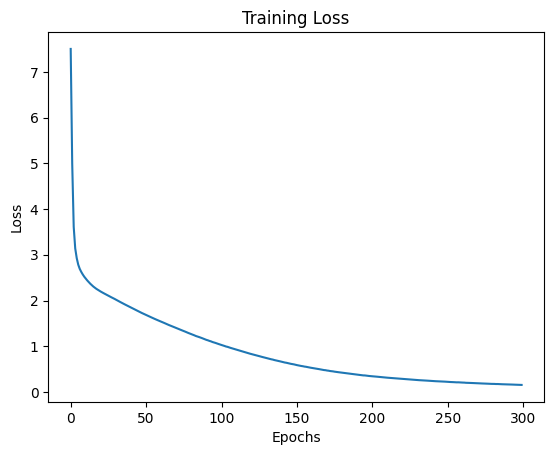

In [ ]:
plot_train_loss(loss_points);

In [ ]:
evaluateRandomly(encoder, decoder)

Input: I want you to wear this.
Ground truth: Eu quero que você use isso.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Eu quero que você soubesse esse assunto.<UNK>

Input: I want to pay in installments.
Ground truth: Quero pagar à prestação.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Eu quero contatá em particular.<UNK>

Input: May I turn the lights off?
Ground truth: Eu poderia desligar as luzes?
Predicted: Mais eu ' a diferença a diferença?

Input: Has Tom quit drinking?
Ground truth: O Tom parou de beber?
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Quando o Tom está sozinho em Boston?<UNK>

Input: Tom is doing much better.
Ground truth: Tom está bem melhor.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Na Tom está fazendo muito melhor.<UNK>



Podemos ver aqui uma melhoria significativa. Ainda encontramos o erro do EOS (embora ele esteja presente no output_dict_reverse) mas podemos ver frases quanse completas ou aparencendo nas frases com palavras a mais. No entanto, veja o exemplo de desligar as luzes, ainda vemos defeitos.

#### E com attention + teacher forcing?

In [ ]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p=0.1):
    """
    Initializes the decoding layer (Decoder with Attention) of an RNN.

    Parameters:
    - hidden_size: The size of the hidden state vector.
    - output_size: The size of the output vocabulary (number of unique words in the target language).
    - dropout_p: The dropout probability for regularization during training.
    """
    super(AttnDecoderRNN, self).__init__()

    # Embedding layer transforms word indices into dense vectors of size 'hidden_size'.
    self.embedding = nn.Embedding(output_size, hidden_size)

    # Attention mechanism to compute context vectors from encoder outputs.
    self.attention = BahdanauAttention(hidden_size)

    # GRU layer that processes the combined input of embeddings and context vectors.
    self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)

    # Linear layer maps the GRU output to the output vocabulary space.
    self.out = nn.Linear(hidden_size, output_size)

    # Dropout layer for regularization to prevent overfitting during training.
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor):
    """
    Defines the forward pass for the attention decoder.

    Parameters:
    - encoder_outputs: The output sequences from the encoder (shape: batch_size, seq_len, hidden_size).
    - encoder_hidden: The last hidden state of the encoder (shape: 1, batch_size, hidden_size).
    - target_tensor: The target sequence for teacher forcing (optional).

    Returns:
    - decoder_outputs: The output probabilities (log-softmax) for each time step (shape: batch_size, seq_len, output_size).
    - decoder_hidden: The final hidden state of the decoder (shape: 1, batch_size, hidden_size).
    - attentions: The attention weights for each time step (shape: batch_size, seq_len).
    """
    batch_size = encoder_outputs.size(0)
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []
    attentions = []

    # Loop through each time step to generate the output sequence.
    for i in range(MAX_LENGTH):
      # Call the forward_step function to get output, hidden state, and attention weights for the current time step.
      decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
      decoder_outputs.append(decoder_output)
      attentions.append(attn_weights)

      if target_tensor is not None:
        # Teacher forcing: Feed the target token as the next input to the decoder.
        decoder_input = target_tensor[:, i].unsqueeze(1)
      else:
        # Without teacher forcing: Use its own predictions as the next input.
        _, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze(-1).detach()  # detach from history as input

    # Concatenate all decoder outputs along the time step dimension.
    decoder_outputs = torch.cat(decoder_outputs, dim=1)

    # Apply log softmax to the outputs to get log-probabilities.
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

    # Concatenate all attention weights along the time step dimension.
    attentions = torch.cat(attentions, dim=1)

    # Return the outputs, final hidden state, and attention weights.
    return decoder_outputs, decoder_hidden, attentions


  def forward_step(self, input, hidden, encoder_outputs):
    """
    Processes a single step in the decoding sequence with attention.

    Parameters:
    - input: The current input to the decoder (shape: batch_size, 1).
    - hidden: The current hidden state of the decoder (shape: 1, batch_size, hidden_size).
    - encoder_outputs: The outputs from the encoder (shape: batch_size, seq_len, hidden_size).

    Returns:
    - output: The predicted output (shape: batch_size, 1, output_size).
    - hidden: The updated hidden state (shape: 1, batch_size, hidden_size).
    - attn_weights: The attention weights for the current input (shape: batch_size, seq_len).
    """
    # Get the embedded representation of the current input with dropout for regularization.
    embedded =  self.dropout(self.embedding(input))

    # Permute hidden state to match the query shape for the attention mechanism.
    query = hidden.permute(1, 0, 2)

    # Compute the context vector and attention weights using the attention mechanism.
    context, attn_weights = self.attention(query, encoder_outputs)

    # Concatenate the embedded input and the context vector for the GRU.
    input_gru = torch.cat((embedded, context), dim=2)

    # Pass the combined input through the GRU layer to get the output and updated hidden state.
    output, hidden = self.gru(input_gru, hidden)

    # Map the GRU output to the output vocabulary space using the linear layer.
    output = self.out(output)

    return output, hidden, attn_weights

In [ ]:
hidden_size = 128
batch_size = 1024

train_dataloader = get_dataloader(batch_size, sampled_pairs, input_dict, output_dict)

encoder = EncoderRNN(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

# decoder = DecoderRNN(
decoder = AttnDecoderRNN(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points = train(train_dataloader, encoder, decoder, 300, learning_rate=0.001)

Epoch:   10/ 300 - Loss: 2.4746
Epoch:   20/ 300 - Loss: 2.1890
Epoch:   30/ 300 - Loss: 2.0290
Epoch:   40/ 300 - Loss: 1.8623
Epoch:   50/ 300 - Loss: 1.7083
Epoch:   60/ 300 - Loss: 1.5723
Epoch:   70/ 300 - Loss: 1.4475
Epoch:   80/ 300 - Loss: 1.3281
Epoch:   90/ 300 - Loss: 1.2180
Epoch:  100/ 300 - Loss: 1.1123
Epoch:  110/ 300 - Loss: 1.0111
Epoch:  120/ 300 - Loss: 0.9184
Epoch:  130/ 300 - Loss: 0.8296
Epoch:  140/ 300 - Loss: 0.7484
Epoch:  150/ 300 - Loss: 0.6739
Epoch:  160/ 300 - Loss: 0.6058
Epoch:  170/ 300 - Loss: 0.5439
Epoch:  180/ 300 - Loss: 0.4886
Epoch:  190/ 300 - Loss: 0.4411
Epoch:  200/ 300 - Loss: 0.3965
Epoch:  210/ 300 - Loss: 0.3588
Epoch:  220/ 300 - Loss: 0.3263
Epoch:  230/ 300 - Loss: 0.2974
Epoch:  240/ 300 - Loss: 0.2712
Epoch:  250/ 300 - Loss: 0.2501
Epoch:  260/ 300 - Loss: 0.2301
Epoch:  270/ 300 - Loss: 0.2109
Epoch:  280/ 300 - Loss: 0.1945
Epoch:  290/ 300 - Loss: 0.1812
Epoch:  300/ 300 - Loss: 0.1668


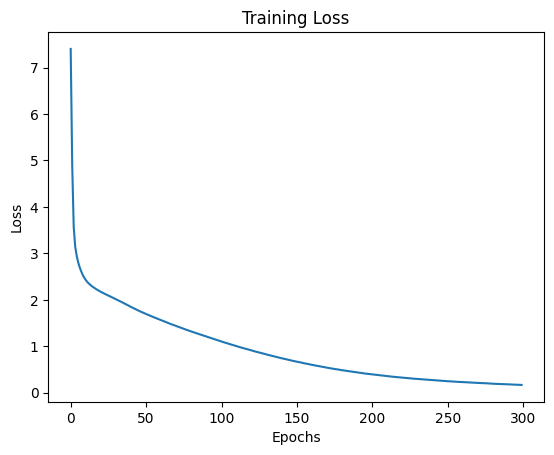

In [ ]:
plot_train_loss(loss_points);

In [ ]:
evaluateRandomly(encoder, decoder)

Input: I hope Tom isn't embarrassed.
Ground truth: Eu espero que o Tom não esteja com vergonha.
Predicted: Por que eu espero que o Tom não 

Input: You are not Japanese.
Ground truth: Você não é japonês.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Não é não estamos noite.<UNK>

Input: She writes with her left hand.
Ground truth: Ela escreve com a mão esquerda.
Predicted: Apesar de amigos do mão de mão.

Input: You've had a really rough day, haven't you?
Ground truth: Você teve um dia bem difícil, não teve?
Predicted: Você já assinou muito bem, não est

Input: Tom knew who was trying to kill him.
Ground truth: Tom sabia quem estava tentando matá-lo.
Predicted: Quando o Tom sabia que foi fácil ele 



## Usando o modelo do PyTorch:

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import gdown

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from matplotlib.ticker import FixedLocator #para fazer gráficos com palavras
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
url = 'https://drive.google.com/uc?id=1Dt96VaplAImAPwJP1-FjHZQiP-0Tcvi1'
file = 'por.txt'
gdown.download(url, file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Dt96VaplAImAPwJP1-FjHZQiP-0Tcvi1
To: /content/por.txt
100%|██████████| 28.3M/28.3M [00:00<00:00, 180MB/s]


'por.txt'

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def get(self, word, default=None):
      return self.word2index.get(word, default)

In [ ]:
# Transforma a palavra em ASCII - American Standard Code for Information Interchange. Se trata de uma forma de codificação que atribui a cada
# caracter, símbolo e comando de controle um valor numérico entre 0 e 127. Isso permite fazer o "indexes from Sentence" de uma maneira sempre igual
# e semelhante.
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Retira os valores com acentos e letras maiúsculas/minúsculas
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

Como temos a tradução entre duas línguas, criamos um dicionário para cada uma delas.

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    lines = open('por.txt', encoding='utf-8').\
        read().strip().split('\n') #Separa cada linha do dataset

    # Separa cada linha em duas frases: de uma língua e de outra língua.
    pairs = [[s for s in l.split('\t')[:2]] for l in lines] #Detalhe aqui para o :2 no final, pois o dataset inclui uma referência ao final.

    # Se considerarmos reverse=True, estamos fazendo a tradução reversa, isto é, se nosso dataset é inglês -> português, ao adicionar o
    #reverse estamos traduzindo de português para inglês.
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 5 #Vai determinar o tamanho máximo da frase que estamos tomando.

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Unimos então estas funções através da preparação dos dados: nela vamos separar os pares em input e ouput, filtrar em frases que tenham no máximo o MAX_LENGTH de palavras e separar conforme a quantidade de dados:

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'por', False)
print(random.choice(pairs))

Reading lines...
Read 193633 sentence pairs
Trimmed to 40762 sentence pairs
Counting words...
Counted words:
eng 10246
por 16389
["It's so boring.", 'Isso é muito chato!']


Definindo o Encoder, exatamente como está definido no modelo do EP.

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'por', False)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, None)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    display(plt.gcf())

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Sem attention

Reading lines...
Read 193633 sentence pairs
Trimmed to 40762 sentence pairs
Counting words...
Counted words:
eng 10246
por 16389
1m 8s (- 21m 49s) (5 5%) 3.0416
2m 8s (- 19m 20s) (10 10%) 1.5965
3m 9s (- 17m 54s) (15 15%) 1.0561
4m 9s (- 16m 39s) (20 20%) 0.8098
5m 10s (- 15m 30s) (25 25%) 0.6831
6m 9s (- 14m 21s) (30 30%) 0.6055
7m 7s (- 13m 14s) (35 35%) 0.5552
8m 7s (- 12m 11s) (40 40%) 0.5206
9m 6s (- 11m 8s) (45 45%) 0.4957
10m 7s (- 10m 7s) (50 50%) 0.4767
11m 7s (- 9m 6s) (55 55%) 0.4627
12m 9s (- 8m 6s) (60 60%) 0.4504
13m 11s (- 7m 6s) (65 65%) 0.4412
14m 13s (- 6m 5s) (70 70%) 0.4336
15m 14s (- 5m 4s) (75 75%) 0.4262
16m 16s (- 4m 4s) (80 80%) 0.4209
17m 16s (- 3m 2s) (85 85%) 0.4155
18m 16s (- 2m 1s) (90 90%) 0.4108
19m 16s (- 1m 0s) (95 95%) 0.4073
20m 18s (- 0m 0s) (100 100%) 0.4037


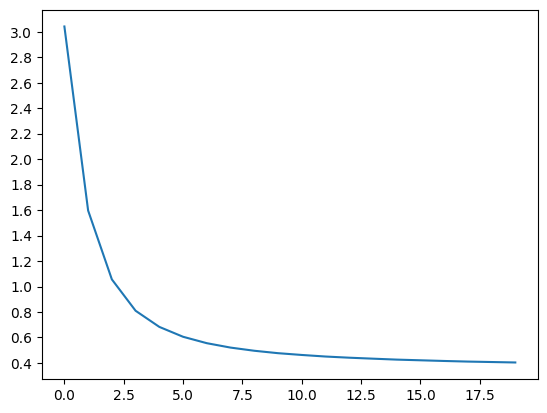

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 100, print_every=5, plot_every=5)


In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> I need medical help.
= Preciso de assistência médica.
< Preciso de assistência médica. <EOS>

> Everything changed.
= Tudo mudou.
< Tudo isso mudou. <EOS>

> Tom saw Mary crying.
= Tom viu Mary chorando.
< Tom viu Mary chorando. <EOS>

> Prices continue to climb.
= Os preços seguem subindo.
< Os preços seguem subindo. <EOS>

> Is Tom any better?
= Tom está melhor?
< Tom está melhor? <EOS>

> I opened the window.
= Eu abri a janela.
< Eu abri a janela. <EOS>

> I'm depressed.
= Estou deprimido.
< Estou estou muito deprimido. <EOS>

> Give us a hand.
= Dê-nos uma mão.
< Dê-nos uma mão. <EOS>

> They're best friends.
= Elas são melhores amigas.
< Eles são melhores amigas. <EOS>

> He will survive.
= Ele vai sobreviver.
< Ele foi de <EOS>



Veja que, mesmo apresentando um erro maior, a tradução deste modelo é muito melhor, não apresentando nenhum caso de delírio nestes exemplos e completando quase todas as traduções perfeitamente.

### Com attention

Reading lines...
Read 193633 sentence pairs
Trimmed to 40762 sentence pairs
Counting words...
Counted words:
eng 10246
por 16389
1m 24s (- 21m 1s) (5 6%) 2.4081
2m 47s (- 19m 33s) (10 12%) 0.8480
4m 11s (- 18m 8s) (15 18%) 0.4525
5m 34s (- 16m 44s) (20 25%) 0.3292
6m 58s (- 15m 20s) (25 31%) 0.2787
8m 21s (- 13m 56s) (30 37%) 0.2519
9m 45s (- 12m 32s) (35 43%) 0.2354
11m 9s (- 11m 9s) (40 50%) 0.2252
12m 32s (- 9m 45s) (45 56%) 0.2174
13m 57s (- 8m 22s) (50 62%) 0.2121
15m 21s (- 6m 58s) (55 68%) 0.2077
16m 44s (- 5m 34s) (60 75%) 0.2048
18m 7s (- 4m 10s) (65 81%) 0.2018
19m 30s (- 2m 47s) (70 87%) 0.1994
20m 54s (- 1m 23s) (75 93%) 0.1980
22m 17s (- 0m 0s) (80 100%) 0.1964


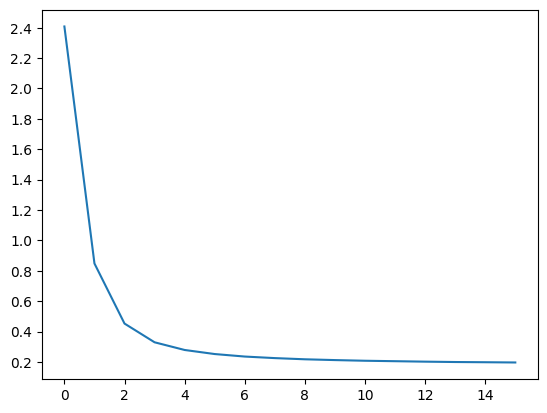

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)


> Tom ordered a drink.
= Tom pediu uma bebida.
< Tom pediu uma bebida. <EOS>

> The bird is dead.
= O passarinho está morto.
< O pássaro está morto. <EOS>

> Tom arrived very early.
= Tom chegou muito cedo.
< Tom chegou muito cedo. <EOS>

> Wait there for me.
= Aguarde-me ali.
< Me espera ali. <EOS>

> What's this used for?
= Para que serve isso?
< Para que serve isso? <EOS>

> It's not a virus.
= Não é um vírus.
< Não é um vírus. <EOS>

> Tom called for help.
= Tom chamou por ajuda.
< Tom chamou por ajuda. <EOS>

> Let's cross our fingers.
= Vamos cruzar os dedos.
< Vamos cruzar os dedos. <EOS>

> Consider yourselves lucky.
= Considerem-se sortudos.
< Considerem-se sortudos. <EOS>

> I ate it.
= Eu comi isso.
< Eu comi isso. <EOS>



Apesar de, ao adicionar atenção, apresentar um erro levemente maior, veja que as traduções ainda estão bem precisas, ou então fazem algum sentido semântico de alguma forma. Nos exemplos acima vemos os erros:
- As senhoras me conhecem? vs Os senhores me conhecem?
- Venham me ver. vs Venha me ver.
- Comece. vs Comece, entre nisso.
- Não grites. vs Não faça nada gritar.

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Definir a localização dos ticks
    ax.xaxis.set_major_locator(FixedLocator(range(len(input_sentence.split(' '))+2)))
    ax.yaxis.set_major_locator(FixedLocator(range(len(output_words)+1)))

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    display(plt.gcf())


def evaluateAndShowAttention(encoder, decoder, n):
    for i in range(n):
      pair = random.choice(pairs)
      output_words,attentions = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
      print('input = ', pair[0])
      print('output = ', ' '.join(output_words))
      showAttention(pair[0], output_words, attentions[0, :len(output_words), :])


input =  Everybody was wrong.
output =  Todo mundo estava errado. <EOS>


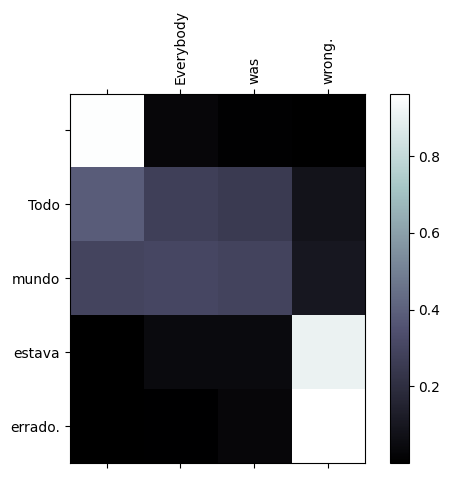

input =  Here are the details.
output =  Aqui estão os detalhes. <EOS>


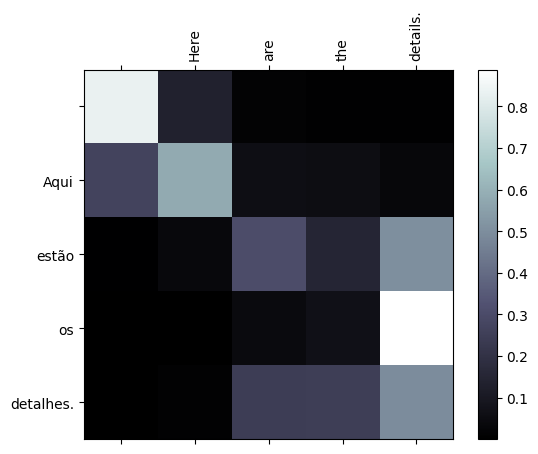

input =  The gates were closed.
output =  Os portões estavam fechados. <EOS>


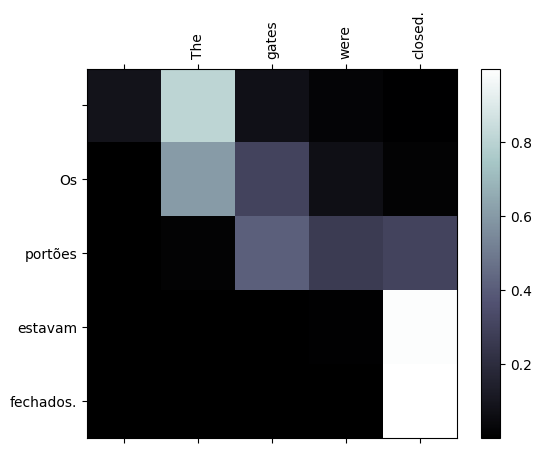

input =  Everyone was asleep.
output =  Todo mundo estava dormindo. <EOS>


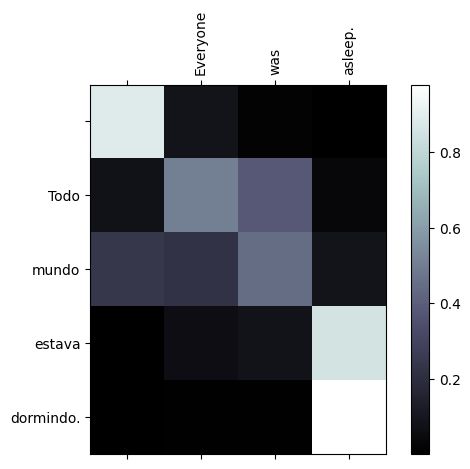

input =  He is well paid.
output =  Ele é bem pago. <EOS>


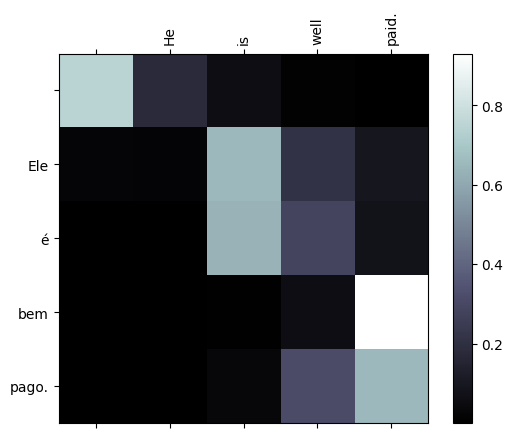

In [ ]:
encoder.eval()
decoder.eval()
evaluateAndShowAttention(encoder, decoder,5)

### e se eu tentar teacher reinforcing?

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
  """
  Train the encoder and decoder for one epoch.

  Parameters:
  - dataloader: Iterable that provides batches of input and target tensors.
  - encoder: The encoder model.
  - decoder: The decoder model.
  - encoder_optimizer: Optimizer for updating the encoder's parameters.
  - decoder_optimizer: Optimizer for updating the decoder's parameters.
  - criterion: Loss function to measure the difference between the predicted and target outputs.

  Returns:
  - The average loss over the epoch.
  """
  total_loss = 0
  for data in dataloader:
    input_tensor, target_tensor = data

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

    loss = criterion(
        decoder_outputs.view(-1, decoder_outputs.size(-1)),
        target_tensor.view(-1)
    )
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

Reading lines...
Read 193633 sentence pairs
Trimmed to 40762 sentence pairs
Counting words...
Counted words:
eng 10246
por 16389
0m 59s (- 18m 50s) (5 5%) 2.5350
1m 54s (- 17m 12s) (10 10%) 1.0169
2m 50s (- 16m 6s) (15 15%) 0.5552
3m 45s (- 15m 0s) (20 20%) 0.3834
4m 40s (- 14m 0s) (25 25%) 0.3079
5m 34s (- 13m 1s) (30 30%) 0.2692
6m 29s (- 12m 4s) (35 35%) 0.2468
7m 24s (- 11m 6s) (40 40%) 0.2319
8m 19s (- 10m 10s) (45 45%) 0.2222
9m 14s (- 9m 14s) (50 50%) 0.2149
10m 9s (- 8m 18s) (55 55%) 0.2094
11m 4s (- 7m 22s) (60 60%) 0.2048
11m 59s (- 6m 27s) (65 65%) 0.2013
12m 53s (- 5m 31s) (70 70%) 0.1986
13m 49s (- 4m 36s) (75 75%) 0.1961
14m 43s (- 3m 40s) (80 80%) 0.1934
15m 38s (- 2m 45s) (85 85%) 0.1920
16m 33s (- 1m 50s) (90 90%) 0.1901
17m 28s (- 0m 55s) (95 95%) 0.1889
18m 23s (- 0m 0s) (100 100%) 0.1881


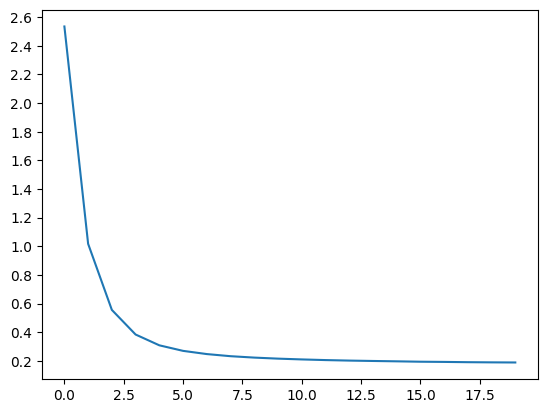

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 100, print_every=5, plot_every=5)


In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> He crossed the street.
= Ele atravessou a rua.
< Ele atravessava a rua. <EOS>

> You're back again.
= Você voltou, de novo.
< Você voltou, outra vez. <EOS>

> He doesn't allow interruptions.
= Ele não admite interrupções.
< Ele não admite interrupções. <EOS>

> Tom whispered.
= Tom sussurrou.
< Tom sussurrou. o traíram. <EOS>

> Are you listening?
= Você está me ouvindo?
< Você está ouvindo? <EOS>

> Don't blame the victim.
= Não culpe a vítima.
< Não culpe a vítima. <EOS>

> I feel horrible.
= Eu me sinto horrivel.
< Sinto-me sem horrível. <EOS>

> This is delicious.
= Isto é delicioso.
< Este peru está delicioso. <EOS>

> We need time.
= Precisamos de tempo.
< Precisamos de tempo. <EOS>

> He loves soccer.
= Ele adora futebol.
< Ele adora futebol. <EOS>



### Mudando o tamanho do batch size

Reading lines...
Read 193633 sentence pairs
Trimmed to 40762 sentence pairs
Counting words...
Counted words:
eng 10246
por 16389
0m 13s (- 4m 14s) (5 5%) 5.1349
0m 25s (- 3m 53s) (10 10%) 3.6403
0m 38s (- 3m 37s) (15 15%) 2.8357
0m 50s (- 3m 23s) (20 20%) 2.2948
1m 3s (- 3m 10s) (25 25%) 1.8908
1m 15s (- 2m 56s) (30 30%) 1.5732
1m 28s (- 2m 43s) (35 35%) 1.3158
1m 40s (- 2m 31s) (40 40%) 1.1071
1m 53s (- 2m 18s) (45 45%) 0.9391
2m 5s (- 2m 5s) (50 50%) 0.8047
2m 18s (- 1m 53s) (55 55%) 0.6968
2m 30s (- 1m 40s) (60 60%) 0.6107
2m 43s (- 1m 27s) (65 65%) 0.5404
2m 55s (- 1m 15s) (70 70%) 0.4835
3m 8s (- 1m 2s) (75 75%) 0.4366
3m 20s (- 0m 50s) (80 80%) 0.3979
3m 33s (- 0m 37s) (85 85%) 0.3650
3m 45s (- 0m 25s) (90 90%) 0.3374
3m 58s (- 0m 12s) (95 95%) 0.3137
4m 10s (- 0m 0s) (100 100%) 0.2935


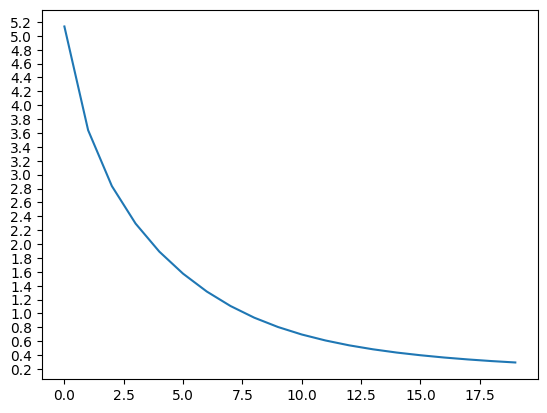

In [ ]:
hidden_size = 128
batch_size = 1024

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 100, print_every=5, plot_every=5)

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> What did you forget?
= O que você esqueceu?
< O que você esqueceu? <EOS>

> Everything is all right.
= Está tudo em ordem.
< Está tudo bem. <EOS>

> Boston is changing.
= Boston está mudando.
< Boston está a vodca? <EOS>

> Who is absent?
= Quem está ausente?
< Quem está comendo isso? <EOS>

> It wasn't my mistake.
= Não foi erro meu.
< Não foi erro meu. <EOS>

> I owe you $30.
= Devo-lhe trinta dólares.
< Devo-lhe trinta dólares. <EOS>

> What did you order?
= O que você pediu?
< O que você pediu? <EOS>

> We're psychics.
= Somos médiuns.
< Somos apenas um apartamento. <EOS>

> I'm not unhappy.
= Não sou infeliz.
< Não sou infeliz. <EOS>

> I'll come right now.
= Já venho.
< Já volto. <EOS>



### Utilizando as frases aleatórias e o modelo do Pytorch

Mas será que isso não é um problema dos dados? Em um dos casos temos frases curtas, no outro temos frases aleatórias.... Vamos verificar isso...

In [ ]:
def readDataset(reverse=False): #Utilizando um link online para realizar puxar o dataset
  url = 'https://drive.google.com/uc?id=1Dt96VaplAImAPwJP1-FjHZQiP-0Tcvi1'
  file = 'por.txt'
  gdown.download(url, file, quiet=False)
  lines = open(file, encoding='utf-8').read().strip().split('\n') #abrindo cada linha
  pairs = [[s for s in l.split('\t')[:2]] for l in lines] #tomando apenas os dois primeiros itens
  # (o dataset vem com uma informação extra na terceira coluna, sendo os créditos de onde foi retirado)
  print()
  print(f'Read {len(pairs)} samples from {file}')
  print()
  print("\n".join(map(str, random.sample(pairs, 15))))
  return  pairs

pairs = readDataset()

Downloading...
From: https://drive.google.com/uc?id=1Dt96VaplAImAPwJP1-FjHZQiP-0Tcvi1
To: /content/por.txt
100%|██████████| 28.3M/28.3M [00:00<00:00, 76.8MB/s]



Read 193633 samples from por.txt

["I said I'd do it.", 'Eu disse que faria.']
["Tom wanted to kiss Mary, but he didn't have the nerve to try.", 'Tom queria beijar Maria, mas ele não tinha a coragem de tentar.']
['She needs you.', 'Ela precisa de você.']
['He is the owner of this land.', 'Ele é o dono desta terra.']
["It's unnecessary.", 'Não é necessária.']
['Her dress is blue with white polka dots.', 'Seu vestido é azul com bolinhas brancas.']
['Tom threw rocks at Mary.', 'Tom atirou pedras em Mary.']
["I can't look at this photo without being reminded of my school days.", 'Não posso olhar essa foto sem me lembrar dos meus dias na escola.']
['I hope that is not the case.', 'Espero que esse não seja o caso.']
['I ended up telling Tom what you told me not to tell him.', 'Eu terminei dizendo a Tom o que você me disse para não dizer a ele.']
['Can you give me an example?', 'Você poderia me dar um exemplo?']
['What would you do if you failed?', 'O que você faria se fracassasse?']
['We us

In [ ]:
sample_size = int(input("Digite o tamanho da amostra: "))
print(f"Amostra de tamanho {sample_size} criada")
sampled_pairs = random.sample(pairs, sample_size)

Digite o tamanho da amostra: 40000
Amostra de tamanho 40000 criada


In [ ]:
SOS_token = 0
EOS_token = 1
space_token = 2


def prepareData(pairs):
  input_dict  = {"SOS": SOS_token, "EOS": EOS_token, " ": space_token}
  output_dict = {"SOS": SOS_token, "EOS": EOS_token, " ": space_token}

  input_dict_reverse  = {SOS_token: "SOS", EOS_token: "EOS", " ": space_token}
  output_dict_reverse = {SOS_token: "SOS", EOS_token: "EOS", " ": space_token}

  for pair in pairs:
    ipt, tgt = pair

    mask = '([^a-zA-Z0-9])' #para tirar todos os inputs que não sejam letras ou números e separar acentos
    result = [token for token in re.split(mask, ipt) if token.strip()]
    for word_input in result:
      if word_input not in input_dict:
        next_int = max(input_dict.values()) + 1
        input_dict[word_input] = next_int
        input_dict_reverse[next_int] = word_input

    for word_output in re.split(mask, tgt):
      if word_output not in output_dict:
        next_int = max(output_dict.values()) + 1
        output_dict[word_output] = next_int
        output_dict_reverse[word_output] = word_output  # Adicione essa linha

  print(f'Number of input words: {len(input_dict.keys())}')
  print(f'Number of output words: {len(output_dict.keys())}')

  return input_dict, output_dict, input_dict_reverse, output_dict_reverse

input_dict, output_dict, input_dict_reverse, output_dict_reverse = prepareData(sampled_pairs)

Number of input words: 8331
Number of output words: 12440


In [ ]:
def indexesFromSentence(language_dict, sentence, verbose=False):
  '''
    Função utilitária para converter uma sentença em índices
  '''
  encoded = []
  for word in re.split('([^a-zA-Z0-9])', sentence):
    if word.strip():
      encoded.append(language_dict.get(word, language_dict[' ']))
    elif word == ' ':
      encoded.append(language_dict[' '])
  if verbose:
    print(f"'{sentence}' => {encoded}")
  return encoded

indexesFromSentence(input_dict, "There's nothing left to worry about.", verbose=True);
indexesFromSentence(output_dict, 'Eu acredito que você gosta do seu trabalho', verbose=True);

'There's nothing left to worry about.' => [50, 13, 87, 2, 1015, 2, 275, 2, 34, 2, 569, 2, 187, 9]
'Eu acredito que você gosta do seu trabalho' => [67, 2, 1778, 2, 37, 2, 129, 28, 2, 220, 2, 175, 2, 697, 2, 177]


In [ ]:
# Funções utilitárias
def tensorFromSentence(language_dict, sentence):
  indexes = indexesFromSentence(language_dict, sentence)
  indexes.insert(0, SOS_token)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_dict, pair[0])
    target_tensor = tensorFromSentence(output_dict, pair[1])
    return (input_tensor, target_tensor)

sample = random.sample(sampled_pairs, 1)
ipt, out = sample[0]
print(f'Input: {ipt}')
print(f'Output: {out}')
tensorsFromPair([ipt,out])

Input: Tom went to Australia.
Output: Tom foi à Austrália.


(tensor([[  0,  31,   2, 500,   2,  34,   2, 306,   9,   1]], device='cuda:0'),
 tensor([[  0,  33,   2,  19,   2, 347,   2, 334,  25, 335,   8,   1]],
        device='cuda:0'))

In [ ]:
def get_dataloader(batch_size, pairs, input_dict, output_dict):
  n = len(pairs)
  input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
  target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

  for idx, (inp, tgt) in enumerate(pairs):
    inp_ids = indexesFromSentence(input_dict, inp)
    tgt_ids = indexesFromSentence(output_dict, tgt)
    inp_ids.append(EOS_token)
    tgt_ids.append(EOS_token)
    input_ids[idx, :min(len(inp_ids), MAX_LENGTH)] = inp_ids[:MAX_LENGTH]
    target_ids[idx, :min(len(tgt_ids), MAX_LENGTH)] = tgt_ids[:MAX_LENGTH]

  train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))

  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  return train_dataloader

2m 17s (- 43m 30s) (5 5%) 1.5076
4m 25s (- 39m 45s) (10 10%) 0.9256
6m 31s (- 37m 0s) (15 15%) 0.7134
8m 41s (- 34m 45s) (20 20%) 0.5855
10m 48s (- 32m 24s) (25 25%) 0.4998
12m 57s (- 30m 13s) (30 30%) 0.4382
15m 6s (- 28m 2s) (35 35%) 0.3924
17m 13s (- 25m 50s) (40 40%) 0.3560
19m 21s (- 23m 39s) (45 45%) 0.3277
21m 29s (- 21m 29s) (50 50%) 0.3038
23m 38s (- 19m 20s) (55 55%) 0.2842
25m 46s (- 17m 10s) (60 60%) 0.2671
27m 54s (- 15m 1s) (65 65%) 0.2528
30m 1s (- 12m 52s) (70 70%) 0.2399
32m 9s (- 10m 43s) (75 75%) 0.2290
34m 18s (- 8m 34s) (80 80%) 0.2188
36m 25s (- 6m 25s) (85 85%) 0.2101
38m 33s (- 4m 17s) (90 90%) 0.2018
40m 41s (- 2m 8s) (95 95%) 0.1947
42m 49s (- 0m 0s) (100 100%) 0.1878


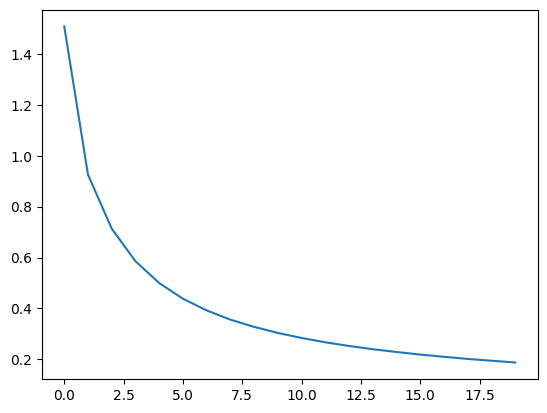

In [ ]:
hidden_size = 128
batch_size = 32
MAX_LENGTH = 18

train_dataloader = get_dataloader(batch_size, sampled_pairs, input_dict, output_dict)

encoder = EncoderRNN(len(input_dict), hidden_size).to(device)
decoder = DecoderRNN(hidden_size, len(output_dict)).to(device)

train(train_dataloader, encoder, decoder, 100, print_every=5, plot_every=5)


In [ ]:
def evaluate(encoder, decoder, sentence):
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
    input_tensor = tensorFromSentence(input_dict, sentence)

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden, target_tensor=None)

    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()

    decoded_words = []
    for idx in decoded_ids:
        # Obter a palavra correspondente ao índice
        # (assumindo que output_dict contém {palavra: índice})

        # Se seu output_dict_reverse for {index: palavra}:
        # word = output_dict_reverse.get(idx.item(), "<UNK>")

        # Se seu output_dict_reverse for {palavra: index} e você tiver o output_dict:
        word = next((word for word, index in output_dict.items() if index == idx.item()), "<UNK>")


        # Verificar se a palavra está no output_dict_reverse
        # (assumindo que output_dict_reverse contém {palavra: índice_reverso})
        # Esse if é apenas para segurança adicional, mas na realidade
        # se a palavra estiver no output_dict, deverá ter uma entrada correspondente
        # no output_dict_reverse. Se isso não estiver ocorrendo o problema esta na
        # criação do output_dict_reverse
        if word in output_dict_reverse:
            decoded_words.append(word)
        else:
            print(f"Palavra não encontrada em output_dict_reverse: {word}")
            decoded_words.append("<UNK>")

        if idx.item() == EOS_token:
            break
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=5):
  for i in range(n):
    pair = random.choice(sampled_pairs)
    print(f'Input: {pair[0]}')
    print(f'Ground truth: {pair[1]}')
    output_words, _ = evaluate(encoder, decoder, pair[0])
    output_sentence = ''.join(output_words)
    print(f'Predicted: {output_sentence}')
    print('')

In [ ]:
evaluateRandomly(encoder, decoder)

Input: I knew you couldn't wait.
Ground truth: Eu sabia que você não podia esperar.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Eu sabia que você queria contar.<UNK>

Input: Tom won't tolerate this.
Ground truth: Tom não vai tolerar isso.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Tom não vai ligar para isso.<UNK>

Input: Tom bought a rug.
Ground truth: Tom comprou um tapete.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Tom comprou um tapete turco.<UNK>

Input: Tom's silence made Mary angry.
Ground truth: O silêncio do Tom fez a Mary ficar furiosa.
Predicted: O silêncio de Tom foi difícil de 

Input: Do you think Tom was annoyed?
Ground truth: Você acha que Tom ficou irritado?
Palavra não encontrada em output_dict_reverse: EOS
Predicted: O que Tom estava triste?<UNK>



e com esta amostra de frases mais longas + attention:

4m 1s (- 76m 20s) (5 5%) 1.3233
7m 51s (- 70m 47s) (10 10%) 0.5835
11m 43s (- 66m 27s) (15 15%) 0.3939
15m 34s (- 62m 19s) (20 20%) 0.3078
19m 27s (- 58m 22s) (25 25%) 0.2574
23m 19s (- 54m 26s) (30 30%) 0.2233
27m 8s (- 50m 24s) (35 35%) 0.1982
30m 58s (- 46m 27s) (40 40%) 0.1793
34m 47s (- 42m 31s) (45 45%) 0.1639
38m 36s (- 38m 36s) (50 50%) 0.1518
42m 23s (- 34m 41s) (55 55%) 0.1417
46m 12s (- 30m 48s) (60 60%) 0.1333
50m 0s (- 26m 55s) (65 65%) 0.1259
53m 48s (- 23m 3s) (70 70%) 0.1199
57m 37s (- 19m 12s) (75 75%) 0.1143
61m 26s (- 15m 21s) (80 80%) 0.1093
65m 14s (- 11m 30s) (85 85%) 0.1046
69m 3s (- 7m 40s) (90 90%) 0.1013
72m 53s (- 3m 50s) (95 95%) 0.0976
76m 41s (- 0m 0s) (100 100%) 0.0952


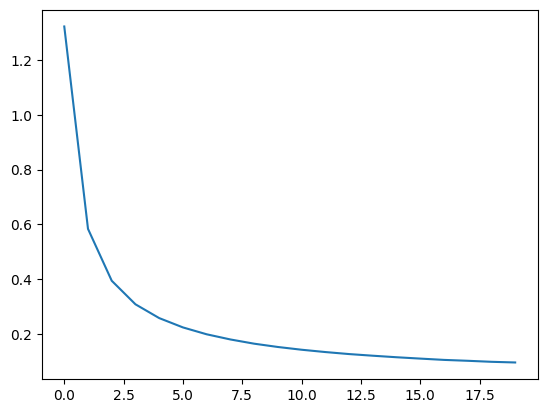

In [ ]:
hidden_size = 128
batch_size = 32
MAX_LENGTH = 18

train_dataloader = get_dataloader(batch_size, sampled_pairs, input_dict, output_dict)

encoder = EncoderRNN(len(input_dict), hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, len(output_dict)).to(device)

train(train_dataloader, encoder, decoder, 100, print_every=5, plot_every=5)


In [ ]:
evaluateRandomly(encoder, decoder)


Input: The pain was unbearable.
Ground truth: A dor era insuportável.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: A dor era insuportável único insuportária.<UNK>

Input: Many people make that mistake.
Ground truth: Muitas pessoas cometem esse erro.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Os carros a fazer isso mesmo.<UNK>

Input: What subjects do you like best?
Ground truth: De qual assunto você mais gosta?
Palavra não encontrada em output_dict_reverse: EOS
Predicted: De qual assunto você mais gosta?<UNK>

Input: We didn't hear Tom leave, but we heard Mary.
Ground truth: Não ouvimos Tom sair, mas ouvimos Mary.
Palavra não encontrada em output_dict_reverse: EOS
Predicted: Não ouvimos Tom sair, mas ouvimos Mary.<UNK>

Input: There is a possibility that we won't have to shut down the factory.
Ground truth: Existe a possibilidade de não termos de fechar a fábrica.
Predicted: Tem uma possibilidade de possibilidade que nós teremos 



Veja que é engraçado que o erro está muito pequeno, mas ao vermos como a tradução está acontecendo realmente, vemos que não está sendo eficiente para frases maiores e amostras aleatórios, mesmo aumentando a amostra e adicionando atenção, e tendo a mesma medida de erro e métodos de otimização.



---



# Problemas e comentários:
1. Inicialmente, gostaria de ter feito um modelo de tradução de português para outra língua, mas estava muito dificil encontrar datasets que ligassem ambos de uma maneira mais acessível. Inclusive, ao pesquisar sobre dataset envolvendo português brasileiro, a maioria que encontrei envolvia a análise de sentimentos de tweets brasileiros (aparentemente, somos famosos online pelo ódio no twitter), uma produção sobre fernando pessoa (https://www.kaggle.com/code/mpwolke/llama-3-2-portuguese-fernando-pessoa) e um dataset da bíblia traduzida em que uma pessoa está tentando treinar uma LLM para responder perguntas referentes a bíblia.  



### Comentários e dúvidas sobre o EP3:
 5. Não há a inclusão do begin of sentence nas palavras codificadas. Para isto deveria incluir uma linha de inclusão do BOS, ou realmente não há a necessidade de usá-lo?  